In [33]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3.common.env_checker import check_env

In [35]:
from IPython.display import HTML
HTML("<style>div.output_area pre { font-family: 'Courier New', monospace; }</style>")

In [36]:
from apad_env import APADEnv, has_islands

Invalid piece placement
row 2, dr 1, col 4, dc 3
piece_id, chirality, rotation, position (1, 1, 1, 18)


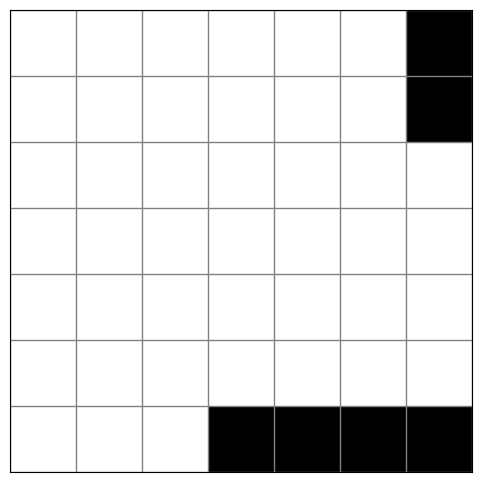

IndexError: 

In [37]:
env = APADEnv()
check_env(env)

Coordinate system: Top left is 0,0. Zeroeth row, second column would be 0,2.

# Basic sanity checks

In [6]:
def test_environment():
    env = APADEnv()
    
    # Test 1: Grid initialization
    assert env.grid.shape == (7, 7)
    assert np.sum(env.grid == -1) in {6, 7, 8}  # Invalid positions
    assert np.sum(env.remaining_pieces) == 8  # All pieces available
    
    # Test 2: Piece coordinate generation
    coords_k = env._get_piece_coords(0, 0, 0)  # K piece, no flip, no rotation
    expected_k = [(0,0), (1,0), (2,0), (3,0), (2,1)]
    assert coords_k == expected_k
    
    # Test 3: Rotation
    coords_k_rot = env._get_piece_coords(0, 0, 1)  # K piece rotated 90°
    assert len(coords_k_rot) == 5
    
    # Test 4: Valid placement
    valid = env._is_valid_placement(0, 0, 0, 14)  # Position (2,0) on grid
    assert isinstance(valid, np.bool_)
    
    # Test 5: Invalid placement (out of bounds)
    valid = env._is_valid_placement(0, 0, 0, 6)  # Top-right corner invalid
    assert valid == False
    
    # Test 6: Piece placement
    if env._is_valid_placement(0, 0, 0, 14):
       env._place_piece_components(0, 0, 0, 14)
       assert not env.remaining_pieces[0]  # Piece marked as used
       assert np.sum(env.grid == 1) == 5   # 5 cells occupied by piece
    
    print("All tests passed")
    
test_environment()

All tests passed


### Make sure we can't place pieces on top of each other. Make sure we can reset the environment.

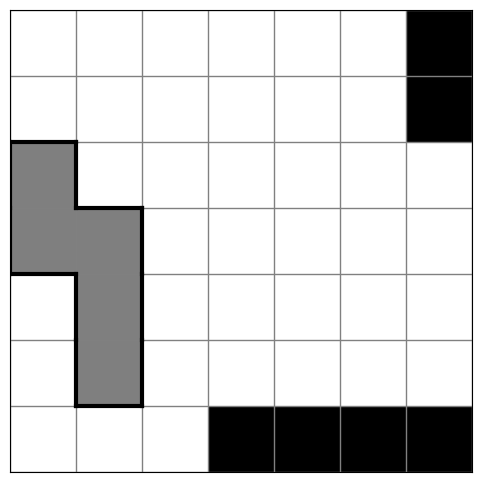

Overlap and reset tests passed!


In [7]:
def test_overlap_and_reset():
    env = APADEnv(-1,-1)
    
    # Find two valid positions for same piece type
    pos1 = 14  # Should be valid
    pos2 = 15  # Adjacent position
    
    # Place first piece
    if env._is_valid_placement(0, 0, 0, pos1):
        env._place_piece_components(1, 0, 0, pos1)
        env.visualize()
       
        # Try to place overlapping piece (should fail)
        overlap_valid = env._is_valid_placement(0, 0, 0, pos2)
        assert overlap_valid == False
        
        # Test reset
        obs, info = env.reset()
        assert np.sum(env.remaining_pieces) == 8  # All pieces available
        assert np.sum(env.grid > 0) == 0  # Only invalid cells marked
       
    print("Overlap and reset tests passed!")
    return env

test_overlap_and_reset()

# Date selection validation

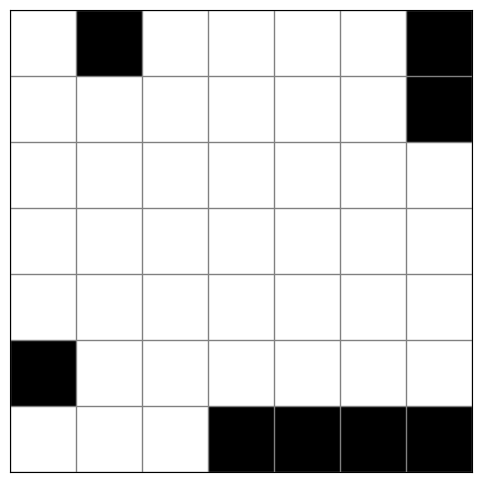

In [8]:
env = APADEnv(2,22) # feb 22
env.visualize()

# Validate island-finding

In [9]:
from scipy.ndimage import label

def validate_island_finding(grid):
    # pass label() a grid of T/F, T where the cells are 0 (empty), F where they are !=0 (invalid/occupied).
    labeled_array, num_features = label(env.grid == 0)
    
    # 1's where there are empty cells, 0's where they are occupied/invalid
    print("here's the grid as the island finder sees it")
    print(labeled_array)
    
    # number of separate groups.
    print(f'there are {num_features} separate islands of unoccupied cells')
    
    # flatten the grid to 1D
    #print(labeled_array.ravel())
    
    # [number of 0s, number of not-zeroes in group1, number of not-zeroes in group2, ...]
    print("\nthe numbers of cells in each group (including the total number of occupied/invalid cells at the zeroeth index)")
    print(np.bincount(labeled_array.ravel()))
    
    island_sizes = np.bincount(labeled_array.ravel())[1:]
    
    # Check if any islands have 4 or fewer cells
    print("\nAre there groups of unoccupied cells of size <= 4?")
    print(np.any(island_sizes <= 4))

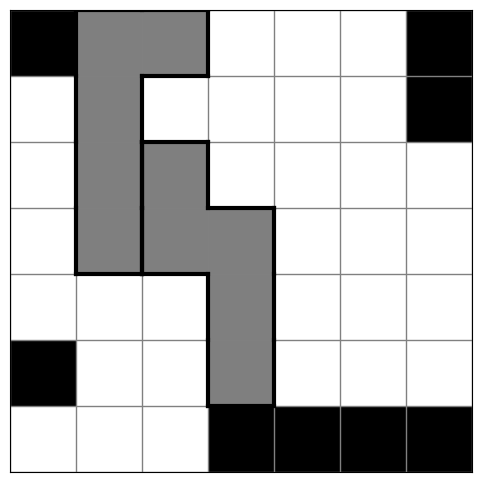

here's the grid as the island finder sees it
[[0 0 0 1 1 1 0]
 [2 0 1 1 1 1 0]
 [2 0 0 1 1 1 1]
 [2 0 0 0 1 1 1]
 [2 2 2 0 1 1 1]
 [0 2 2 0 1 1 1]
 [2 2 2 0 0 0 0]]
there are 2 separate islands of unoccupied cells

the numbers of cells in each group (including the total number of occupied/invalid cells at the zeroeth index)
[18 20 11]

Are there groups of unoccupied cells of size <= 4?
False


In [10]:
env = APADEnv(1,22)
env._place_piece_components(6, 0, 0, 1)
env._place_piece_components(1, 0, 0, 16)
#env._place_piece_components(2, 0, 0, 4)
env.visualize()
validate_island_finding(env.grid)
assert not has_islands(env.grid)

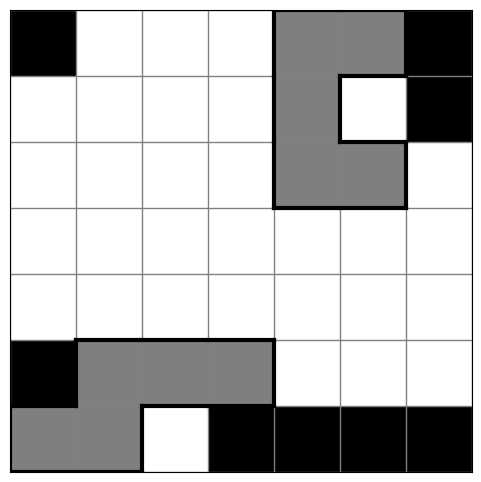

here's the grid as the island finder sees it
[[0 1 1 1 0 0 0]
 [1 1 1 1 0 2 0]
 [1 1 1 1 0 0 1]
 [1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1]
 [0 0 0 0 1 1 1]
 [0 0 3 0 0 0 0]]
there are 3 separate islands of unoccupied cells

the numbers of cells in each group (including the total number of occupied/invalid cells at the zeroeth index)
[18 29  1  1]

Are there groups of unoccupied cells of size <= 4?
True


In [11]:
# we'll allow single islands because in the case where we don't restric solutions, 2 empty singles is the win con
env = APADEnv(1,22)
env._place_piece_components(1, 0, 1, 35)
env._place_piece_components(2, 0, 0, 4)
env.visualize()
validate_island_finding(env.grid)
assert not has_islands(env.grid)

# Piece placement visualization and sanity-checks
Make sure pieces are being placed correctly. And understand the action->position/piece/rotation/chirality encoding.
e.g. 
- action 2408 = Z piece placed in the top-left
- action 2451 = Z piece placed int he top-left, but rotated
- 2451 - 2408 = 43 possible cells where each piece can be placed
- in practice, not all of these cells are valid, even if the board is empty

Chosen action: {'piece_id': 7, 'chirality': 0, 'rotation': 0, 'position': 0, 'grid_pos': (0, 0), 'piece_name': 'Z'}


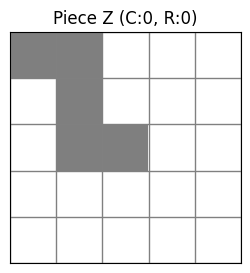

In [12]:
env = APADEnv()
action = 2408
print(f"Chosen action: {env.decode_action_verbose(action)}")
env.visualize_piece(action)

Chosen action: {'piece_id': 7, 'chirality': 0, 'rotation': 1, 'position': 0, 'grid_pos': (0, 0), 'piece_name': 'Z'}


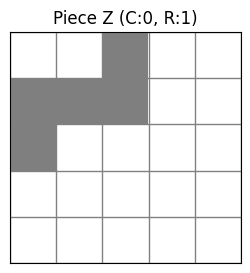

In [13]:
action = 2451
print(f"Chosen action: {env.decode_action_verbose(action)}")
env.visualize_piece(action)

At action 2580 (=2451+3*43, for the 3 remaining rotation configurations in each possible cell), we get our first chirality flip for the z-piece

Chosen action: {'piece_id': 7, 'chirality': 1, 'rotation': 0, 'position': 0, 'grid_pos': (0, 0), 'piece_name': 'Z'}


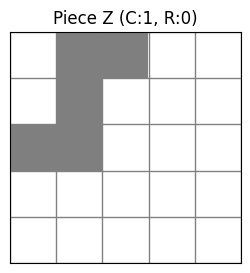

In [14]:
action = 2580
print(f"Chosen action: {env.decode_action_verbose(action)}")
env.visualize_piece(action)

# Action Masking validation

In [15]:
env = APADEnv()
assert env.action_masks().shape == (env.action_space.n,)

# of valid actions 773


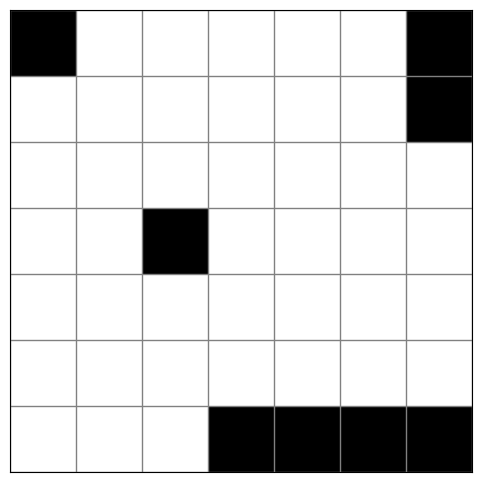

In [16]:
env = APADEnv(1,10)
mask = env.action_masks()
print(f'# of valid actions {np.flatnonzero(mask).size}')
env.visualize()

# Run through a single random game

In [45]:
def test_random_trial(mon=None, day=None):
    env = APADEnv(mon,day)
    #env = APADEnv()
    obs, _ = env.reset()
    done = truncated = False

    while not (done or truncated):
        # Ask the environment which actions are legal right now
        mask = env.action_masks()              # boolean array
        valid_actions = np.flatnonzero(mask)   # integer indices of True values

        if valid_actions.size == 0:
            # No possible moves ⇒ truncate / end the episode
            truncated = True
            break

        action = np.random.choice(valid_actions)
        obs, reward, done, truncated, info = env.step(action)
    
    return env, done, truncated, action

Win? False. Lose? True. Has islands? True


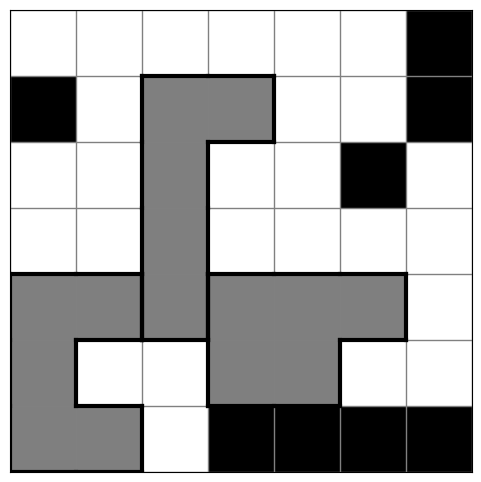

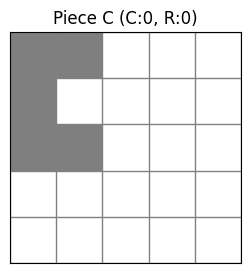

In [46]:
env, done, truncated, terminal_action = test_random_trial()
print(f'Win? {done}. Lose? {truncated}. Has islands? {has_islands(env.grid)}')
env.visualize()
env.visualize_piece(terminal_action)

# Play random trials
now that we require specific date solutions, we don't get random wins

trial 208 15.0 seconds elapsed... 13.82 games/second, wins: 0
trial 416 30.1 seconds elapsed... 13.82 games/second, wins: 0
trial 621 45.1 seconds elapsed... 13.76 games/second, wins: 0
trial 820 60.2 seconds elapsed... 13.63 games/second, wins: 0
trial 1022 75.2 seconds elapsed... 13.59 games/second, wins: 0
trial 1229 90.3 seconds elapsed... 13.62 games/second, wins: 0
trial 1430 105.3 seconds elapsed... 13.58 games/second, wins: 0
trial 1638 120.3 seconds elapsed... 13.62 games/second, wins: 0
trial 1840 135.3 seconds elapsed... 13.60 games/second, wins: 0
trial 2044 150.3 seconds elapsed... 13.60 games/second, wins: 0
trial 2225 165.4 seconds elapsed... 13.45 games/second, wins: 0
trial 2422 180.4 seconds elapsed... 13.43 games/second, wins: 0
trial 2618 195.4 seconds elapsed... 13.40 games/second, wins: 0
trial 2816 210.5 seconds elapsed... 13.38 games/second, wins: 0
trial 3012 225.5 seconds elapsed... 13.36 games/second, wins: 0
trial 3207 240.5 seconds elapsed... 13.33 games/se

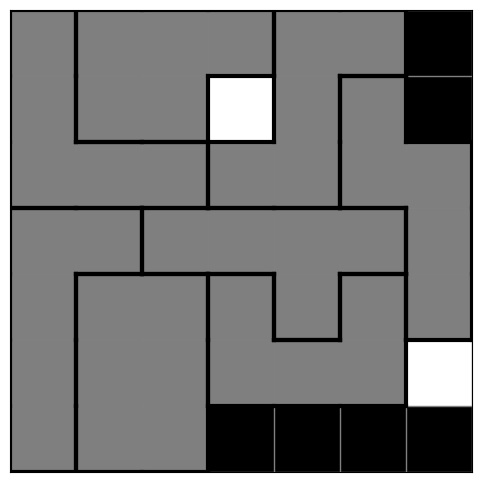

trial 5616 421.2 seconds elapsed... 13.33 games/second, wins: 1
trial 5823 436.2 seconds elapsed... 13.35 games/second, wins: 1
trial 6026 451.3 seconds elapsed... 13.35 games/second, wins: 1
trial 6230 466.3 seconds elapsed... 13.36 games/second, wins: 1
trial 6432 481.3 seconds elapsed... 13.36 games/second, wins: 1
trial 6632 496.3 seconds elapsed... 13.36 games/second, wins: 1
trial 6835 511.4 seconds elapsed... 13.37 games/second, wins: 1
trial 7036 526.4 seconds elapsed... 13.37 games/second, wins: 1
trial 7243 541.5 seconds elapsed... 13.38 games/second, wins: 1
trial 7446 556.5 seconds elapsed... 13.38 games/second, wins: 1
trial 7648 571.6 seconds elapsed... 13.38 games/second, wins: 1
trial 7858 586.6 seconds elapsed... 13.39 games/second, wins: 1
trial 8069 601.7 seconds elapsed... 13.41 games/second, wins: 1
trial 8280 616.7 seconds elapsed... 13.43 games/second, wins: 1
trial 8494 631.8 seconds elapsed... 13.44 games/second, wins: 1
trial 8712 646.8 seconds elapsed... 13.4

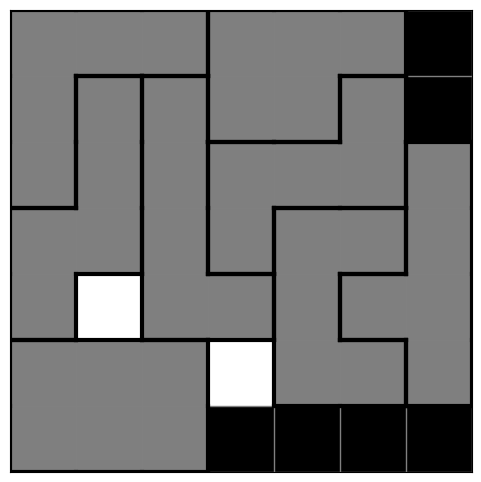

trial 11506 842.4 seconds elapsed... 13.66 games/second, wins: 2
trial 11721 857.4 seconds elapsed... 13.67 games/second, wins: 2
trial 11932 872.4 seconds elapsed... 13.68 games/second, wins: 2
trial 12151 887.5 seconds elapsed... 13.69 games/second, wins: 2
trial 12369 902.6 seconds elapsed... 13.70 games/second, wins: 2
trial 12585 917.6 seconds elapsed... 13.72 games/second, wins: 2
trial 12791 932.6 seconds elapsed... 13.72 games/second, wins: 2
trial 13008 947.6 seconds elapsed... 13.73 games/second, wins: 2
trial 13222 962.7 seconds elapsed... 13.73 games/second, wins: 2
trial 13429 977.7 seconds elapsed... 13.74 games/second, wins: 2
trial 13628 992.7 seconds elapsed... 13.73 games/second, wins: 2
trial 13831 1007.8 seconds elapsed... 13.72 games/second, wins: 2
trial 14044 1022.8 seconds elapsed... 13.73 games/second, wins: 2
trial 14254 1037.8 seconds elapsed... 13.73 games/second, wins: 2
trial 14462 1052.9 seconds elapsed... 13.74 games/second, wins: 2
trial 14667 1067.9 se

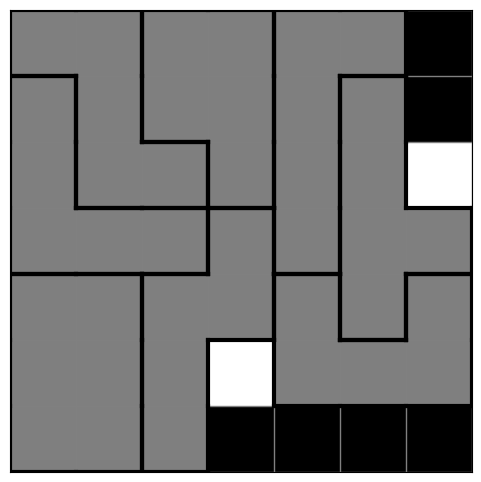

trial 24947 1835.1 seconds elapsed... 13.59 games/second, wins: 3
trial 25146 1850.1 seconds elapsed... 13.59 games/second, wins: 3
trial 25345 1865.2 seconds elapsed... 13.59 games/second, wins: 3
trial 25548 1880.3 seconds elapsed... 13.59 games/second, wins: 3
trial 25749 1895.3 seconds elapsed... 13.59 games/second, wins: 3
trial 25949 1910.4 seconds elapsed... 13.58 games/second, wins: 3
trial 26147 1925.5 seconds elapsed... 13.58 games/second, wins: 3
trial 26351 1940.5 seconds elapsed... 13.58 games/second, wins: 3
trial 26551 1955.5 seconds elapsed... 13.58 games/second, wins: 3
trial 26751 1970.6 seconds elapsed... 13.58 games/second, wins: 3
trial 26948 1985.6 seconds elapsed... 13.57 games/second, wins: 3
trial 27148 2000.6 seconds elapsed... 13.57 games/second, wins: 3
trial 27347 2015.6 seconds elapsed... 13.57 games/second, wins: 3
trial 27546 2030.6 seconds elapsed... 13.57 games/second, wins: 3
trial 27745 2045.7 seconds elapsed... 13.56 games/second, wins: 3
trial 2794

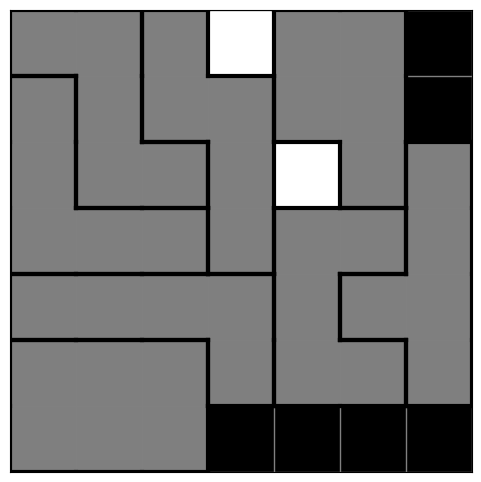

trial 51226 6835.4 seconds elapsed... 7.49 games/second, wins: 4
trial 51431 6850.5 seconds elapsed... 7.51 games/second, wins: 4
trial 51638 6865.5 seconds elapsed... 7.52 games/second, wins: 4
trial 51848 6880.6 seconds elapsed... 7.54 games/second, wins: 4
trial 52054 6895.6 seconds elapsed... 7.55 games/second, wins: 4
trial 52265 6910.7 seconds elapsed... 7.56 games/second, wins: 4
trial 52476 6925.7 seconds elapsed... 7.58 games/second, wins: 4
trial 52684 6940.7 seconds elapsed... 7.59 games/second, wins: 4
trial 52895 6955.8 seconds elapsed... 7.60 games/second, wins: 4
trial 53105 6970.9 seconds elapsed... 7.62 games/second, wins: 4
trial 53311 6985.9 seconds elapsed... 7.63 games/second, wins: 4
trial 53524 7000.9 seconds elapsed... 7.65 games/second, wins: 4
trial 53731 7015.9 seconds elapsed... 7.66 games/second, wins: 4
trial 53938 7031.0 seconds elapsed... 7.67 games/second, wins: 4
trial 54145 7046.0 seconds elapsed... 7.68 games/second, wins: 4
trial 54357 7061.1 second

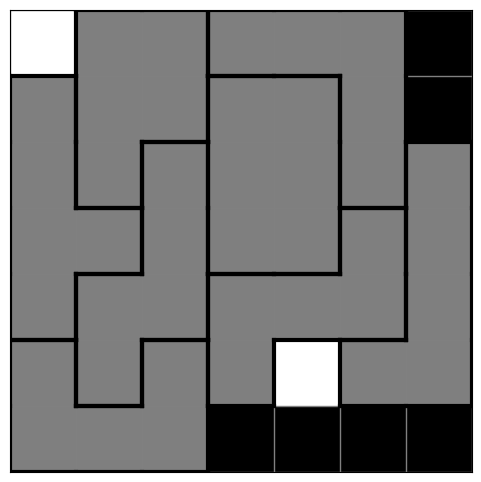

trial 78848 8989.7 seconds elapsed... 8.77 games/second, wins: 5
trial 79057 9004.8 seconds elapsed... 8.78 games/second, wins: 5
trial 79264 9019.8 seconds elapsed... 8.79 games/second, wins: 5
trial 79470 9034.8 seconds elapsed... 8.80 games/second, wins: 5
trial 79679 9049.9 seconds elapsed... 8.80 games/second, wins: 5
trial 79884 9065.0 seconds elapsed... 8.81 games/second, wins: 5
trial 80094 9080.0 seconds elapsed... 8.82 games/second, wins: 5
trial 80307 9095.0 seconds elapsed... 8.83 games/second, wins: 5
trial 80515 9110.1 seconds elapsed... 8.84 games/second, wins: 5
trial 80724 9125.1 seconds elapsed... 8.85 games/second, wins: 5
trial 80935 9140.1 seconds elapsed... 8.85 games/second, wins: 5
trial 81142 9155.2 seconds elapsed... 8.86 games/second, wins: 5
trial 81349 9170.2 seconds elapsed... 8.87 games/second, wins: 5
trial 81559 9185.3 seconds elapsed... 8.88 games/second, wins: 5
trial 81762 9200.3 seconds elapsed... 8.89 games/second, wins: 5
trial 81968 9215.4 second

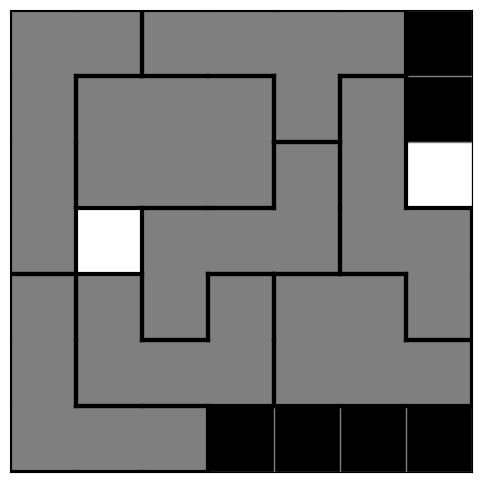

trial 83004 9290.6 seconds elapsed... 8.93 games/second, wins: 6
trial 83211 9305.6 seconds elapsed... 8.94 games/second, wins: 6
trial 83421 9320.7 seconds elapsed... 8.95 games/second, wins: 6
trial 83626 9335.7 seconds elapsed... 8.96 games/second, wins: 6
trial 83830 9350.7 seconds elapsed... 8.97 games/second, wins: 6
trial 84040 9365.8 seconds elapsed... 8.97 games/second, wins: 6
trial 84250 9380.8 seconds elapsed... 8.98 games/second, wins: 6
trial 84457 9395.8 seconds elapsed... 8.99 games/second, wins: 6
trial 84666 9410.9 seconds elapsed... 9.00 games/second, wins: 6
trial 84876 9425.9 seconds elapsed... 9.00 games/second, wins: 6
trial 85080 9440.9 seconds elapsed... 9.01 games/second, wins: 6
trial 85288 9456.0 seconds elapsed... 9.02 games/second, wins: 6
trial 85495 9471.0 seconds elapsed... 9.03 games/second, wins: 6
trial 85700 9486.0 seconds elapsed... 9.03 games/second, wins: 6
trial 85908 9501.1 seconds elapsed... 9.04 games/second, wins: 6
trial 86117 9516.1 second

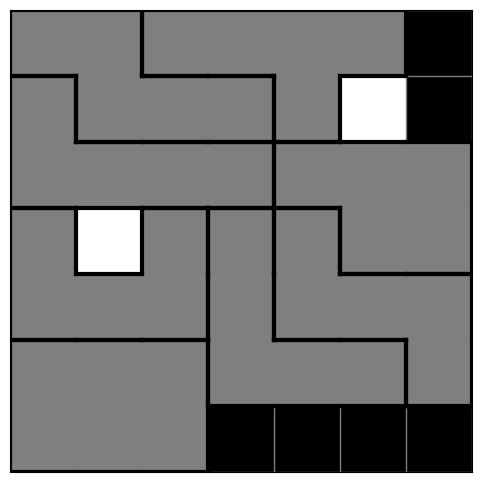

trial 90890 9862.0 seconds elapsed... 9.22 games/second, wins: 7
trial 91093 9877.0 seconds elapsed... 9.22 games/second, wins: 7
trial 91302 9892.1 seconds elapsed... 9.23 games/second, wins: 7
trial 91510 9907.1 seconds elapsed... 9.24 games/second, wins: 7
trial 91719 9922.1 seconds elapsed... 9.24 games/second, wins: 7
trial 91926 9937.1 seconds elapsed... 9.25 games/second, wins: 7
trial 92132 9952.1 seconds elapsed... 9.26 games/second, wins: 7
trial 92344 9967.1 seconds elapsed... 9.26 games/second, wins: 7
trial 92556 9982.2 seconds elapsed... 9.27 games/second, wins: 7
trial 92760 9997.2 seconds elapsed... 9.28 games/second, wins: 7
trial 92972 10012.3 seconds elapsed... 9.29 games/second, wins: 7
trial 93181 10027.3 seconds elapsed... 9.29 games/second, wins: 7
trial 93384 10042.4 seconds elapsed... 9.30 games/second, wins: 7
trial 93594 10057.4 seconds elapsed... 9.31 games/second, wins: 7
trial 93800 10072.4 seconds elapsed... 9.31 games/second, wins: 7
trial 94005 10087.4 

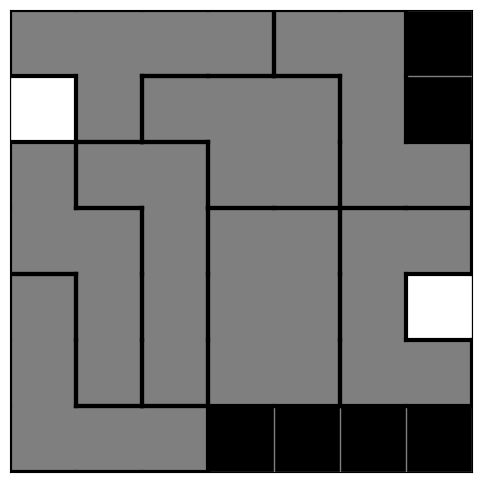

trial 108896 13149.0 seconds elapsed... 8.28 games/second, wins: 8
trial 109099 13164.0 seconds elapsed... 8.29 games/second, wins: 8
trial 109308 13179.0 seconds elapsed... 8.29 games/second, wins: 8
trial 109515 13194.1 seconds elapsed... 8.30 games/second, wins: 8
trial 109719 13209.1 seconds elapsed... 8.31 games/second, wins: 8
trial 109923 13224.1 seconds elapsed... 8.31 games/second, wins: 8
trial 110133 13239.2 seconds elapsed... 8.32 games/second, wins: 8
trial 110336 13254.2 seconds elapsed... 8.32 games/second, wins: 8
trial 110544 13269.3 seconds elapsed... 8.33 games/second, wins: 8
trial 110750 13284.3 seconds elapsed... 8.34 games/second, wins: 8
trial 110956 13299.3 seconds elapsed... 8.34 games/second, wins: 8
trial 111163 13314.4 seconds elapsed... 8.35 games/second, wins: 8
trial 111369 13329.5 seconds elapsed... 8.36 games/second, wins: 8
trial 111573 13344.5 seconds elapsed... 8.36 games/second, wins: 8
trial 111776 13359.5 seconds elapsed... 8.37 games/second, win

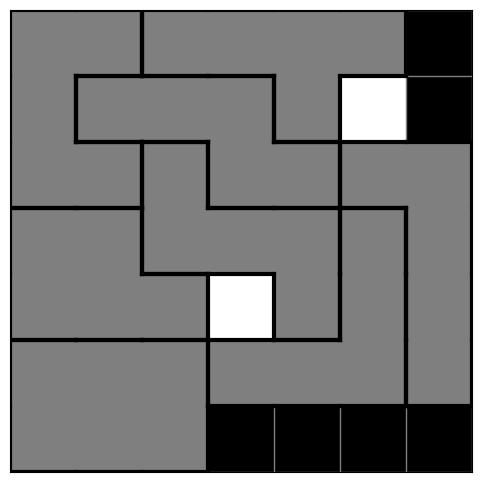

trial 113016 13449.6 seconds elapsed... 8.40 games/second, wins: 9
trial 113222 13464.6 seconds elapsed... 8.41 games/second, wins: 9
trial 113424 13479.7 seconds elapsed... 8.41 games/second, wins: 9
trial 113628 13494.7 seconds elapsed... 8.42 games/second, wins: 9
trial 113836 13509.7 seconds elapsed... 8.43 games/second, wins: 9
trial 114040 13524.8 seconds elapsed... 8.43 games/second, wins: 9
trial 114248 13539.8 seconds elapsed... 8.44 games/second, wins: 9
trial 114455 13554.9 seconds elapsed... 8.44 games/second, wins: 9
trial 114661 13569.9 seconds elapsed... 8.45 games/second, wins: 9
trial 114869 13585.0 seconds elapsed... 8.46 games/second, wins: 9
trial 115078 13600.1 seconds elapsed... 8.46 games/second, wins: 9
trial 115283 13615.1 seconds elapsed... 8.47 games/second, wins: 9
trial 115493 13630.2 seconds elapsed... 8.47 games/second, wins: 9
trial 115705 13645.2 seconds elapsed... 8.48 games/second, wins: 9
trial 115908 13660.2 seconds elapsed... 8.49 games/second, win

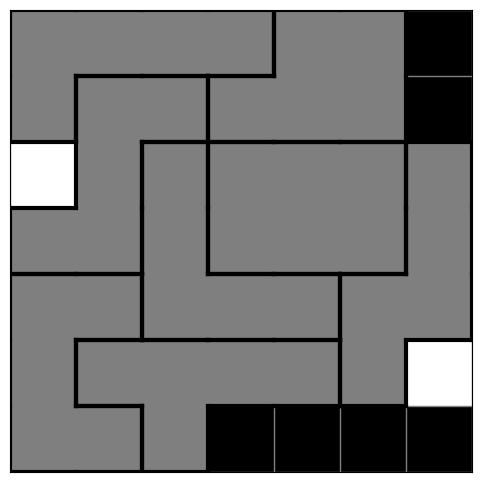

trial 127265 14487.4 seconds elapsed... 8.78 games/second, wins: 10
trial 127423 15531.7 seconds elapsed... 8.20 games/second, wins: 10
trial 127625 15546.7 seconds elapsed... 8.21 games/second, wins: 10
trial 127830 15561.7 seconds elapsed... 8.21 games/second, wins: 10
trial 128041 15576.8 seconds elapsed... 8.22 games/second, wins: 10
trial 128242 15591.8 seconds elapsed... 8.22 games/second, wins: 10
trial 128451 15606.9 seconds elapsed... 8.23 games/second, wins: 10
trial 128594 16640.7 seconds elapsed... 7.73 games/second, wins: 10
trial 128796 16655.8 seconds elapsed... 7.73 games/second, wins: 10
trial 129007 16670.8 seconds elapsed... 7.74 games/second, wins: 10
trial 129219 16685.8 seconds elapsed... 7.74 games/second, wins: 10
trial 129425 16700.8 seconds elapsed... 7.75 games/second, wins: 10
trial 129635 16715.9 seconds elapsed... 7.76 games/second, wins: 10


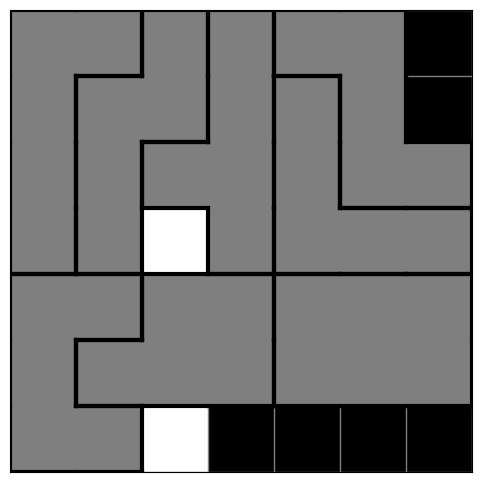

trial 129844 16730.9 seconds elapsed... 7.76 games/second, wins: 11
trial 130052 16746.0 seconds elapsed... 7.77 games/second, wins: 11
trial 130262 16761.0 seconds elapsed... 7.77 games/second, wins: 11
trial 130471 16776.0 seconds elapsed... 7.78 games/second, wins: 11
trial 130676 16791.0 seconds elapsed... 7.78 games/second, wins: 11
trial 130882 16806.1 seconds elapsed... 7.79 games/second, wins: 11
trial 131092 16821.1 seconds elapsed... 7.79 games/second, wins: 11
trial 131299 16836.2 seconds elapsed... 7.80 games/second, wins: 11
trial 131506 16851.2 seconds elapsed... 7.80 games/second, wins: 11


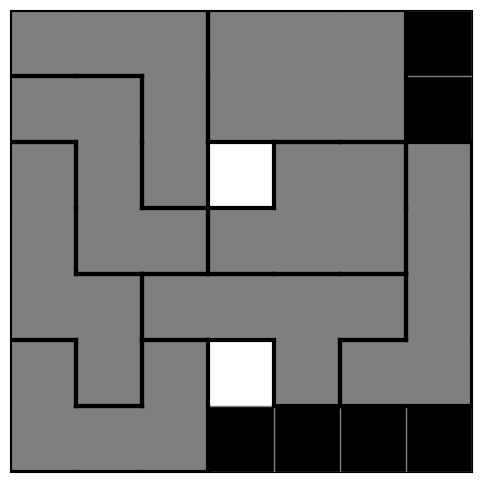

trial 131711 16866.2 seconds elapsed... 7.81 games/second, wins: 12
trial 131914 16881.2 seconds elapsed... 7.81 games/second, wins: 12
trial 132125 16896.3 seconds elapsed... 7.82 games/second, wins: 12
trial 132334 16911.4 seconds elapsed... 7.83 games/second, wins: 12
trial 132536 16926.4 seconds elapsed... 7.83 games/second, wins: 12
trial 132744 16941.4 seconds elapsed... 7.84 games/second, wins: 12
trial 132952 16956.5 seconds elapsed... 7.84 games/second, wins: 12
trial 133150 16971.5 seconds elapsed... 7.85 games/second, wins: 12
trial 133354 16986.5 seconds elapsed... 7.85 games/second, wins: 12
trial 133552 17001.6 seconds elapsed... 7.86 games/second, wins: 12
trial 133746 17016.7 seconds elapsed... 7.86 games/second, wins: 12
trial 133945 17031.7 seconds elapsed... 7.86 games/second, wins: 12
trial 134141 17046.8 seconds elapsed... 7.87 games/second, wins: 12
trial 134334 17061.8 seconds elapsed... 7.87 games/second, wins: 12
trial 134533 17076.9 seconds elapsed... 7.88 gam

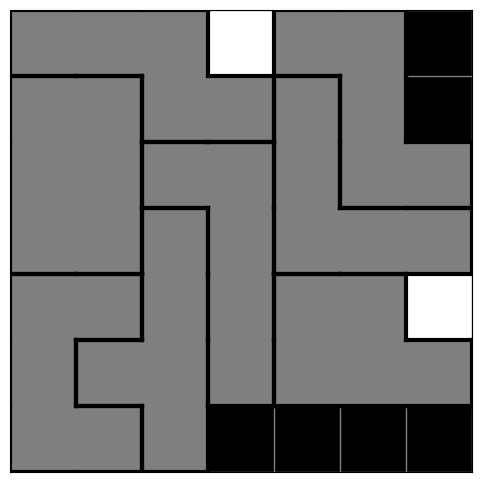

trial 153772 18746.8 seconds elapsed... 8.20 games/second, wins: 13
trial 153941 18761.9 seconds elapsed... 8.20 games/second, wins: 13
trial 154109 18776.9 seconds elapsed... 8.21 games/second, wins: 13
trial 154274 18792.0 seconds elapsed... 8.21 games/second, wins: 13
trial 154436 18807.0 seconds elapsed... 8.21 games/second, wins: 13
trial 154600 18822.1 seconds elapsed... 8.21 games/second, wins: 13
trial 154767 18837.1 seconds elapsed... 8.22 games/second, wins: 13
trial 154934 18852.2 seconds elapsed... 8.22 games/second, wins: 13
trial 155088 18867.3 seconds elapsed... 8.22 games/second, wins: 13
trial 155255 18882.3 seconds elapsed... 8.22 games/second, wins: 13
trial 155422 18897.4 seconds elapsed... 8.22 games/second, wins: 13
trial 155589 18912.4 seconds elapsed... 8.23 games/second, wins: 13
trial 155744 18927.5 seconds elapsed... 8.23 games/second, wins: 13
trial 155906 18942.6 seconds elapsed... 8.23 games/second, wins: 13
trial 156069 18957.6 seconds elapsed... 8.23 gam

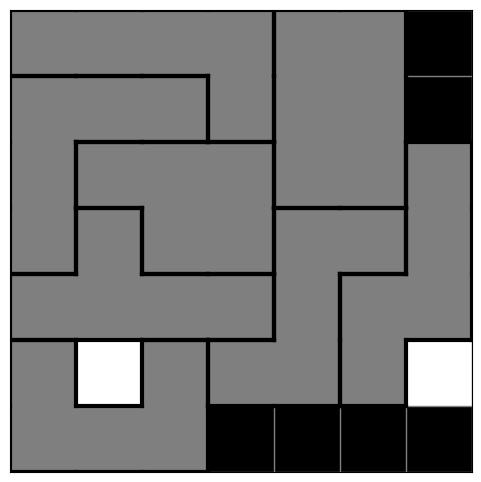

trial 164274 19559.0 seconds elapsed... 8.40 games/second, wins: 14
trial 164480 19574.0 seconds elapsed... 8.40 games/second, wins: 14
trial 164686 19589.0 seconds elapsed... 8.41 games/second, wins: 14
trial 164894 19604.1 seconds elapsed... 8.41 games/second, wins: 14
trial 165104 19619.1 seconds elapsed... 8.42 games/second, wins: 14
trial 165311 19634.2 seconds elapsed... 8.42 games/second, wins: 14
trial 165519 19649.2 seconds elapsed... 8.42 games/second, wins: 14
trial 165728 19664.2 seconds elapsed... 8.43 games/second, wins: 14
trial 165933 19679.3 seconds elapsed... 8.43 games/second, wins: 14
trial 166137 19694.3 seconds elapsed... 8.44 games/second, wins: 14
trial 166344 19709.4 seconds elapsed... 8.44 games/second, wins: 14
trial 166550 19724.4 seconds elapsed... 8.44 games/second, wins: 14
trial 166757 19739.5 seconds elapsed... 8.45 games/second, wins: 14
trial 166965 19754.5 seconds elapsed... 8.45 games/second, wins: 14
trial 167168 19769.6 seconds elapsed... 8.46 gam

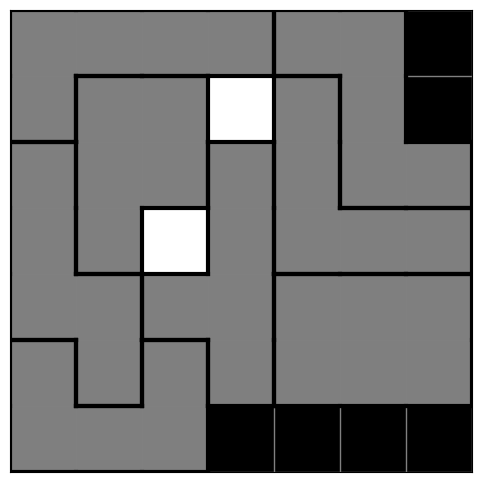

trial 173377 20220.7 seconds elapsed... 8.57 games/second, wins: 15


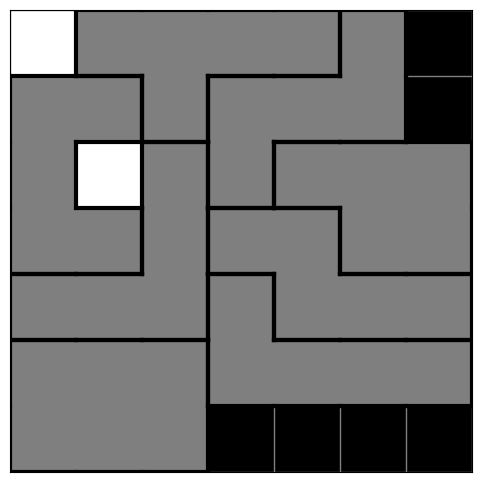

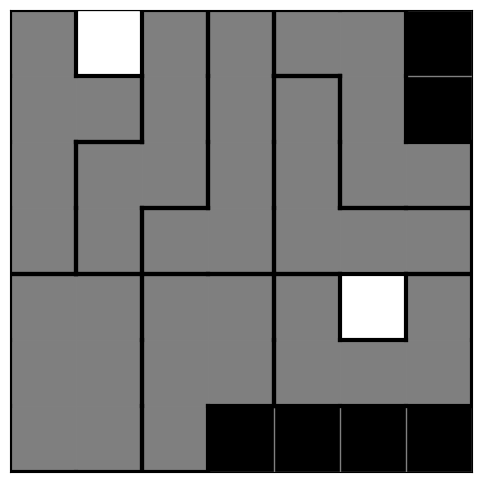

trial 173583 20235.8 seconds elapsed... 8.58 games/second, wins: 17
trial 173786 20250.8 seconds elapsed... 8.58 games/second, wins: 17
trial 173996 20265.9 seconds elapsed... 8.59 games/second, wins: 17
trial 174198 20280.9 seconds elapsed... 8.59 games/second, wins: 17
trial 174403 20296.0 seconds elapsed... 8.59 games/second, wins: 17
trial 174616 20311.0 seconds elapsed... 8.60 games/second, wins: 17
trial 174825 20326.1 seconds elapsed... 8.60 games/second, wins: 17
trial 175034 20341.1 seconds elapsed... 8.60 games/second, wins: 17
trial 175245 20356.2 seconds elapsed... 8.61 games/second, wins: 17
trial 175449 20371.2 seconds elapsed... 8.61 games/second, wins: 17
trial 175660 20386.2 seconds elapsed... 8.62 games/second, wins: 17
trial 175869 20401.2 seconds elapsed... 8.62 games/second, wins: 17
trial 176077 20416.2 seconds elapsed... 8.62 games/second, wins: 17
trial 176287 20431.2 seconds elapsed... 8.63 games/second, wins: 17
trial 176493 20446.3 seconds elapsed... 8.63 gam

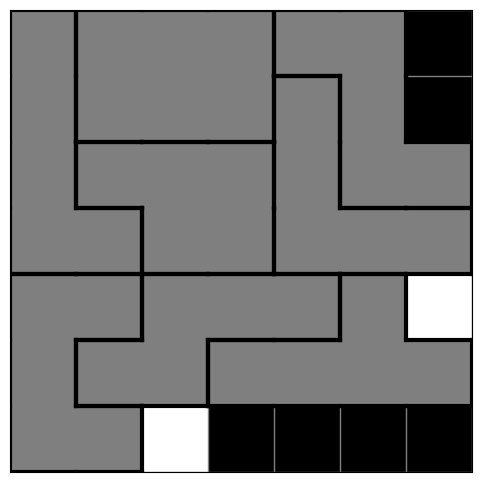

trial 182255 21331.6 seconds elapsed... 8.54 games/second, wins: 18
trial 182277 21674.6 seconds elapsed... 8.41 games/second, wins: 18
trial 182464 21689.6 seconds elapsed... 8.41 games/second, wins: 18
trial 182673 21704.6 seconds elapsed... 8.42 games/second, wins: 18
trial 182878 21719.6 seconds elapsed... 8.42 games/second, wins: 18
trial 183085 21734.7 seconds elapsed... 8.42 games/second, wins: 18
trial 183290 21749.7 seconds elapsed... 8.43 games/second, wins: 18
trial 183499 21764.7 seconds elapsed... 8.43 games/second, wins: 18
trial 183702 21779.8 seconds elapsed... 8.43 games/second, wins: 18
trial 183907 21794.8 seconds elapsed... 8.44 games/second, wins: 18
trial 184115 21809.8 seconds elapsed... 8.44 games/second, wins: 18
trial 184321 21824.8 seconds elapsed... 8.45 games/second, wins: 18
trial 184526 21839.8 seconds elapsed... 8.45 games/second, wins: 18
trial 184735 21854.9 seconds elapsed... 8.45 games/second, wins: 18
trial 184945 21870.0 seconds elapsed... 8.46 gam

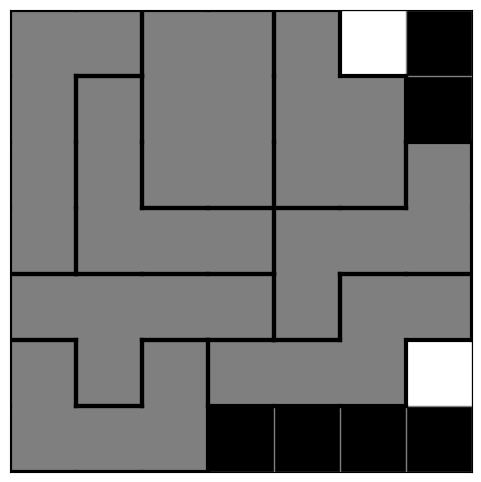

trial 191382 22335.9 seconds elapsed... 8.57 games/second, wins: 19
trial 191589 22351.0 seconds elapsed... 8.57 games/second, wins: 19
trial 191796 22366.0 seconds elapsed... 8.58 games/second, wins: 19
trial 192007 22381.0 seconds elapsed... 8.58 games/second, wins: 19
trial 192216 22396.0 seconds elapsed... 8.58 games/second, wins: 19
trial 192425 22411.1 seconds elapsed... 8.59 games/second, wins: 19
trial 192636 22426.1 seconds elapsed... 8.59 games/second, wins: 19
trial 192840 22441.1 seconds elapsed... 8.59 games/second, wins: 19
trial 193047 22456.2 seconds elapsed... 8.60 games/second, wins: 19
trial 193253 22471.2 seconds elapsed... 8.60 games/second, wins: 19
trial 193458 22486.3 seconds elapsed... 8.60 games/second, wins: 19
trial 193666 22501.3 seconds elapsed... 8.61 games/second, wins: 19
trial 193877 22516.3 seconds elapsed... 8.61 games/second, wins: 19
trial 194084 22531.3 seconds elapsed... 8.61 games/second, wins: 19
trial 194289 22546.3 seconds elapsed... 8.62 gam

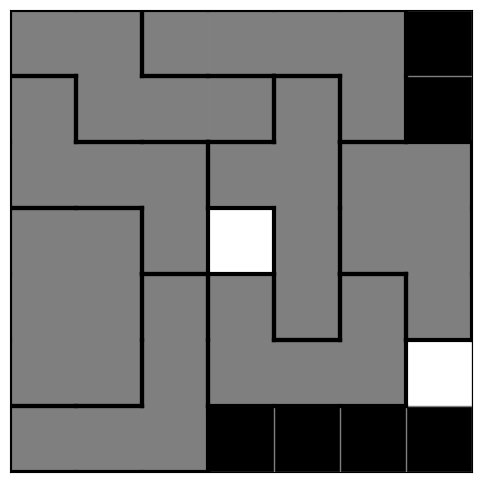

trial 194496 22561.4 seconds elapsed... 8.62 games/second, wins: 20
trial 194705 22576.4 seconds elapsed... 8.62 games/second, wins: 20
trial 194915 22591.4 seconds elapsed... 8.63 games/second, wins: 20
trial 195124 22606.5 seconds elapsed... 8.63 games/second, wins: 20
trial 195330 22621.5 seconds elapsed... 8.63 games/second, wins: 20
trial 195539 22636.5 seconds elapsed... 8.64 games/second, wins: 20
trial 195747 22651.5 seconds elapsed... 8.64 games/second, wins: 20
trial 195952 22666.6 seconds elapsed... 8.64 games/second, wins: 20
trial 196158 22681.6 seconds elapsed... 8.65 games/second, wins: 20
trial 196361 22696.6 seconds elapsed... 8.65 games/second, wins: 20
trial 196566 22711.6 seconds elapsed... 8.65 games/second, wins: 20
trial 196774 22726.7 seconds elapsed... 8.66 games/second, wins: 20
trial 196983 22741.8 seconds elapsed... 8.66 games/second, wins: 20
trial 197192 22756.8 seconds elapsed... 8.67 games/second, wins: 20
trial 197404 22771.9 seconds elapsed... 8.67 gam

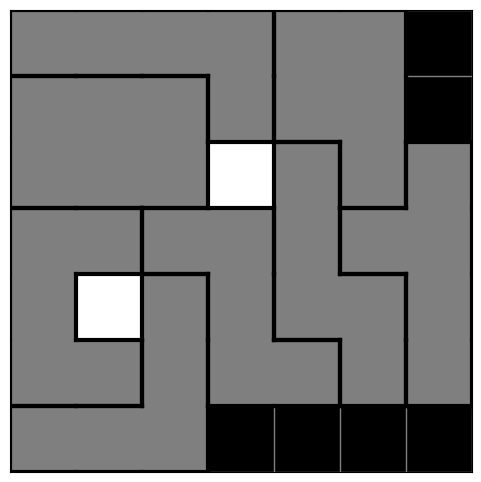

trial 211109 24732.7 seconds elapsed... 8.54 games/second, wins: 21
trial 211162 25404.6 seconds elapsed... 8.31 games/second, wins: 21
trial 211371 25419.7 seconds elapsed... 8.32 games/second, wins: 21
trial 211576 25434.8 seconds elapsed... 8.32 games/second, wins: 21
trial 211787 25449.8 seconds elapsed... 8.32 games/second, wins: 21
trial 211809 26393.6 seconds elapsed... 8.03 games/second, wins: 21
trial 212016 26408.6 seconds elapsed... 8.03 games/second, wins: 21
trial 212225 26423.6 seconds elapsed... 8.03 games/second, wins: 21
trial 212436 26438.7 seconds elapsed... 8.04 games/second, wins: 21
trial 212461 26686.0 seconds elapsed... 7.96 games/second, wins: 21
trial 212666 26701.1 seconds elapsed... 7.96 games/second, wins: 21
trial 212870 26716.1 seconds elapsed... 7.97 games/second, wins: 21
trial 213077 26731.1 seconds elapsed... 7.97 games/second, wins: 21
trial 213101 26937.5 seconds elapsed... 7.91 games/second, wins: 21
trial 213303 26952.6 seconds elapsed... 7.91 gam

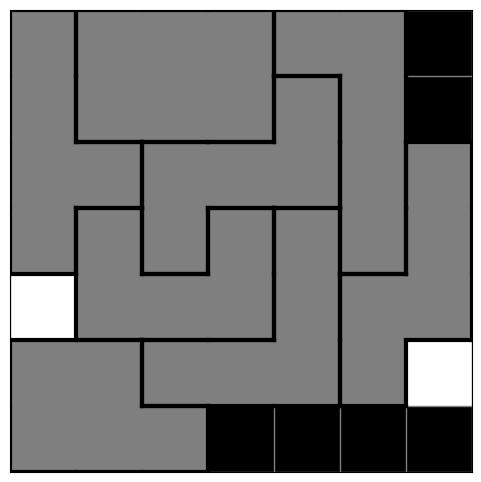

trial 217666 27552.1 seconds elapsed... 7.90 games/second, wins: 22
trial 217763 28521.6 seconds elapsed... 7.64 games/second, wins: 22
trial 217971 28536.6 seconds elapsed... 7.64 games/second, wins: 22
trial 218173 28551.7 seconds elapsed... 7.64 games/second, wins: 22
trial 218383 28566.7 seconds elapsed... 7.64 games/second, wins: 22
trial 218590 28581.8 seconds elapsed... 7.65 games/second, wins: 22
trial 218797 28596.8 seconds elapsed... 7.65 games/second, wins: 22
trial 219009 28611.8 seconds elapsed... 7.65 games/second, wins: 22
trial 219215 28626.9 seconds elapsed... 7.66 games/second, wins: 22
trial 219430 28642.0 seconds elapsed... 7.66 games/second, wins: 22
trial 219643 28657.0 seconds elapsed... 7.66 games/second, wins: 22
trial 219662 29447.7 seconds elapsed... 7.46 games/second, wins: 22
trial 219870 29462.7 seconds elapsed... 7.46 games/second, wins: 22
trial 220081 29477.8 seconds elapsed... 7.47 games/second, wins: 22
trial 220293 29492.8 seconds elapsed... 7.47 gam

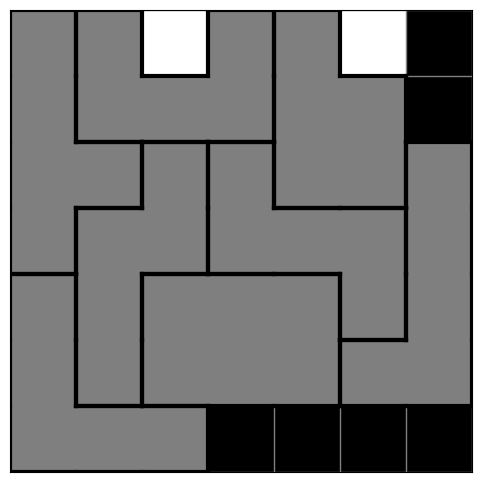

trial 227671 32302.7 seconds elapsed... 7.05 games/second, wins: 23
trial 227876 32317.7 seconds elapsed... 7.05 games/second, wins: 23
trial 228088 32332.7 seconds elapsed... 7.05 games/second, wins: 23
trial 228297 32347.8 seconds elapsed... 7.06 games/second, wins: 23
trial 228503 32362.9 seconds elapsed... 7.06 games/second, wins: 23
trial 228711 32377.9 seconds elapsed... 7.06 games/second, wins: 23
trial 228747 33107.6 seconds elapsed... 6.91 games/second, wins: 23
trial 228952 33122.6 seconds elapsed... 6.91 games/second, wins: 23
trial 229158 33137.7 seconds elapsed... 6.92 games/second, wins: 23
trial 229369 33152.7 seconds elapsed... 6.92 games/second, wins: 23
trial 229394 33524.3 seconds elapsed... 6.84 games/second, wins: 23
trial 229601 33539.4 seconds elapsed... 6.85 games/second, wins: 23
trial 229806 33554.4 seconds elapsed... 6.85 games/second, wins: 23
trial 230019 33569.5 seconds elapsed... 6.85 games/second, wins: 23
trial 230232 33584.5 seconds elapsed... 6.86 gam

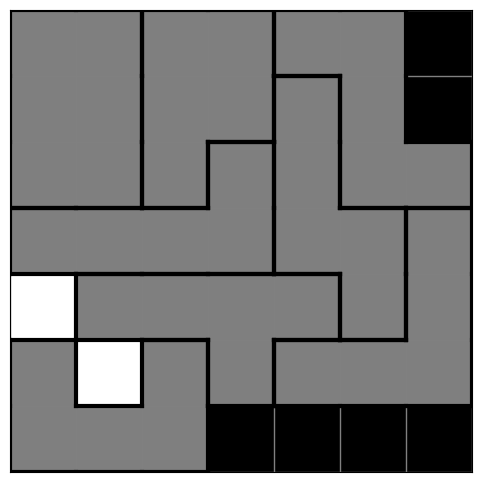

trial 234551 36921.7 seconds elapsed... 6.35 games/second, wins: 24
trial 234758 36936.7 seconds elapsed... 6.36 games/second, wins: 24
trial 234783 37206.8 seconds elapsed... 6.31 games/second, wins: 24
trial 234988 37221.9 seconds elapsed... 6.31 games/second, wins: 24
trial 235194 37236.9 seconds elapsed... 6.32 games/second, wins: 24
trial 235407 37251.9 seconds elapsed... 6.32 games/second, wins: 24
trial 235614 37266.9 seconds elapsed... 6.32 games/second, wins: 24
trial 235822 37282.0 seconds elapsed... 6.33 games/second, wins: 24
trial 236031 37297.0 seconds elapsed... 6.33 games/second, wins: 24
trial 236238 37312.1 seconds elapsed... 6.33 games/second, wins: 24
trial 236445 37327.2 seconds elapsed... 6.33 games/second, wins: 24
trial 236511 38330.6 seconds elapsed... 6.17 games/second, wins: 24
trial 236718 38345.6 seconds elapsed... 6.17 games/second, wins: 24
trial 236927 38360.7 seconds elapsed... 6.18 games/second, wins: 24
trial 237136 38375.7 seconds elapsed... 6.18 gam

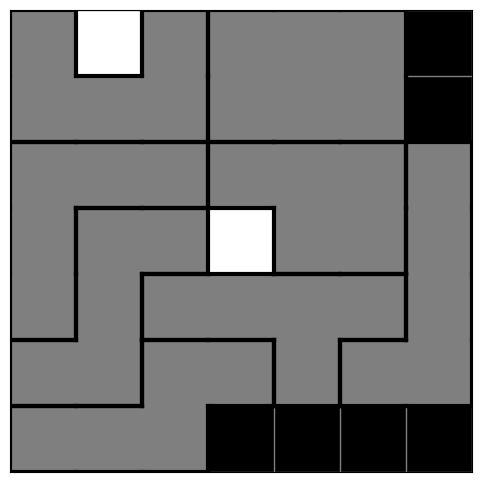

trial 242085 40358.9 seconds elapsed... 6.00 games/second, wins: 25
trial 242295 40374.0 seconds elapsed... 6.00 games/second, wins: 25
trial 242319 40812.6 seconds elapsed... 5.94 games/second, wins: 25
trial 242528 40827.6 seconds elapsed... 5.94 games/second, wins: 25
trial 242740 40842.6 seconds elapsed... 5.94 games/second, wins: 25
trial 242952 40857.7 seconds elapsed... 5.95 games/second, wins: 25
trial 242974 41773.6 seconds elapsed... 5.82 games/second, wins: 25
trial 243178 41788.6 seconds elapsed... 5.82 games/second, wins: 25
trial 243388 41803.6 seconds elapsed... 5.82 games/second, wins: 25
trial 243596 41818.6 seconds elapsed... 5.83 games/second, wins: 25
trial 243622 42780.7 seconds elapsed... 5.69 games/second, wins: 25
trial 243825 42795.7 seconds elapsed... 5.70 games/second, wins: 25
trial 244026 42810.7 seconds elapsed... 5.70 games/second, wins: 25
trial 244237 42825.8 seconds elapsed... 5.70 games/second, wins: 25
trial 244443 42840.8 seconds elapsed... 5.71 gam

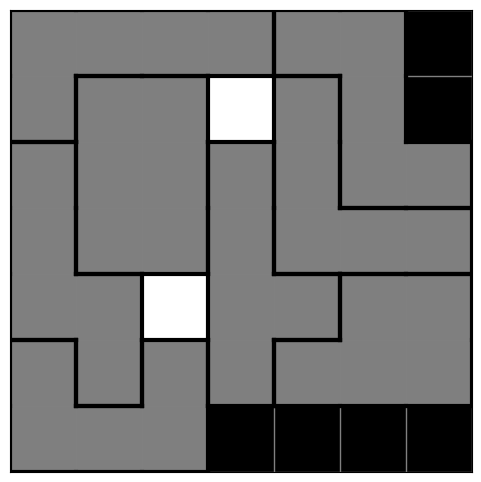

trial 246873 45455.8 seconds elapsed... 5.43 games/second, wins: 26
trial 247080 45470.8 seconds elapsed... 5.43 games/second, wins: 26
trial 247286 45485.9 seconds elapsed... 5.44 games/second, wins: 26
trial 247492 45501.0 seconds elapsed... 5.44 games/second, wins: 26
trial 247699 45516.0 seconds elapsed... 5.44 games/second, wins: 26
trial 247709 46537.6 seconds elapsed... 5.32 games/second, wins: 26
trial 247912 46552.7 seconds elapsed... 5.33 games/second, wins: 26
trial 248122 46567.7 seconds elapsed... 5.33 games/second, wins: 26
trial 248331 46582.7 seconds elapsed... 5.33 games/second, wins: 26
trial 248536 46597.7 seconds elapsed... 5.33 games/second, wins: 26
trial 248747 46612.8 seconds elapsed... 5.34 games/second, wins: 26
trial 248954 46627.8 seconds elapsed... 5.34 games/second, wins: 26
trial 249161 46642.9 seconds elapsed... 5.34 games/second, wins: 26
trial 249367 46657.9 seconds elapsed... 5.34 games/second, wins: 26


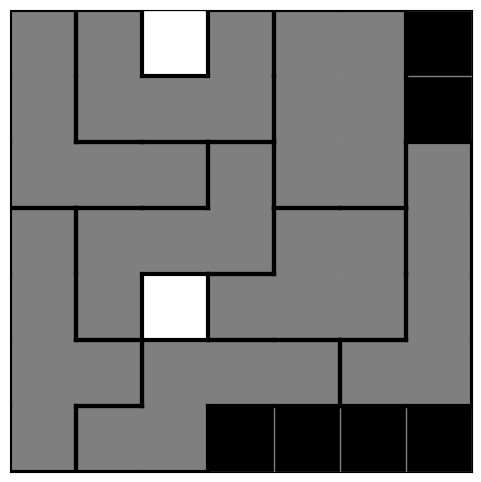

trial 249538 47085.6 seconds elapsed... 5.30 games/second, wins: 27
trial 249745 47100.6 seconds elapsed... 5.30 games/second, wins: 27
trial 249960 47115.6 seconds elapsed... 5.31 games/second, wins: 27
trial 250168 47130.7 seconds elapsed... 5.31 games/second, wins: 27
trial 250370 47145.7 seconds elapsed... 5.31 games/second, wins: 27
trial 250584 47160.8 seconds elapsed... 5.31 games/second, wins: 27
trial 250797 47175.8 seconds elapsed... 5.32 games/second, wins: 27
trial 251002 47190.8 seconds elapsed... 5.32 games/second, wins: 27
trial 251208 47205.8 seconds elapsed... 5.32 games/second, wins: 27
trial 251417 47220.9 seconds elapsed... 5.32 games/second, wins: 27
trial 251427 47486.6 seconds elapsed... 5.29 games/second, wins: 27
trial 251635 47501.6 seconds elapsed... 5.30 games/second, wins: 27
trial 251845 47516.7 seconds elapsed... 5.30 games/second, wins: 27
trial 252056 47531.7 seconds elapsed... 5.30 games/second, wins: 27
trial 252262 47546.7 seconds elapsed... 5.31 gam

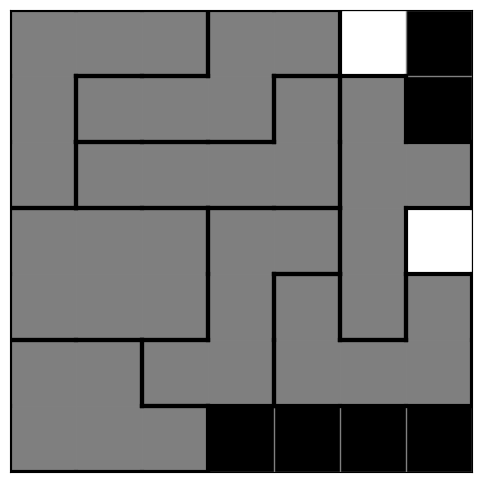

trial 261375 52642.7 seconds elapsed... 4.97 games/second, wins: 28
trial 261585 52657.8 seconds elapsed... 4.97 games/second, wins: 28
trial 261790 52672.8 seconds elapsed... 4.97 games/second, wins: 28
trial 261997 52687.8 seconds elapsed... 4.97 games/second, wins: 28
trial 262205 52702.8 seconds elapsed... 4.98 games/second, wins: 28
trial 262416 52717.9 seconds elapsed... 4.98 games/second, wins: 28
trial 262621 52733.0 seconds elapsed... 4.98 games/second, wins: 28
trial 262831 52748.0 seconds elapsed... 4.98 games/second, wins: 28
trial 263038 52763.0 seconds elapsed... 4.99 games/second, wins: 28
trial 263251 52778.1 seconds elapsed... 4.99 games/second, wins: 28
trial 263462 52793.2 seconds elapsed... 4.99 games/second, wins: 28
trial 263667 52808.2 seconds elapsed... 4.99 games/second, wins: 28
trial 263723 52838.6 seconds elapsed... 4.99 games/second, wins: 28
trial 263929 52853.6 seconds elapsed... 4.99 games/second, wins: 28
trial 264137 52868.7 seconds elapsed... 5.00 gam

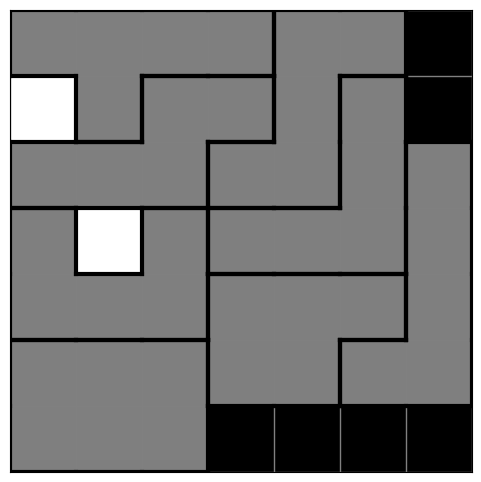

trial 294282 59658.1 seconds elapsed... 4.93 games/second, wins: 29
trial 294484 59673.1 seconds elapsed... 4.93 games/second, wins: 29
trial 294688 59688.1 seconds elapsed... 4.94 games/second, wins: 29
trial 294896 59703.2 seconds elapsed... 4.94 games/second, wins: 29
trial 295102 59718.2 seconds elapsed... 4.94 games/second, wins: 29
trial 295310 59733.2 seconds elapsed... 4.94 games/second, wins: 29
trial 295520 59748.3 seconds elapsed... 4.95 games/second, wins: 29
trial 295723 59763.4 seconds elapsed... 4.95 games/second, wins: 29
trial 295938 59778.4 seconds elapsed... 4.95 games/second, wins: 29
trial 296152 59793.4 seconds elapsed... 4.95 games/second, wins: 29
trial 296359 59808.4 seconds elapsed... 4.96 games/second, wins: 29
trial 296564 59823.4 seconds elapsed... 4.96 games/second, wins: 29
trial 296776 59838.4 seconds elapsed... 4.96 games/second, wins: 29
trial 296979 59853.5 seconds elapsed... 4.96 games/second, wins: 29
trial 297188 59868.6 seconds elapsed... 4.96 gam

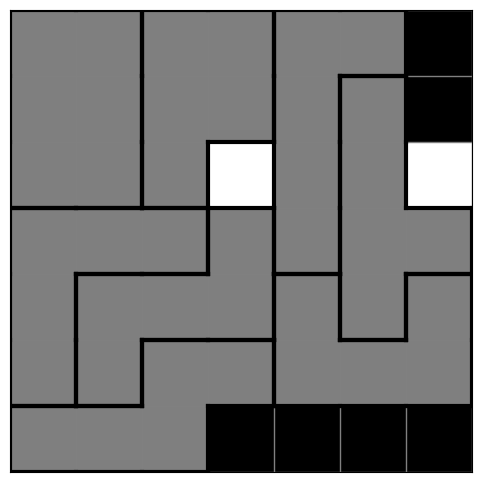

trial 300086 60079.2 seconds elapsed... 4.99 games/second, wins: 30
trial 300294 60094.2 seconds elapsed... 5.00 games/second, wins: 30
trial 300499 60109.2 seconds elapsed... 5.00 games/second, wins: 30
trial 300711 60124.2 seconds elapsed... 5.00 games/second, wins: 30
trial 300921 60139.2 seconds elapsed... 5.00 games/second, wins: 30
trial 301129 60154.3 seconds elapsed... 5.01 games/second, wins: 30
trial 301341 60169.3 seconds elapsed... 5.01 games/second, wins: 30
trial 301546 60184.4 seconds elapsed... 5.01 games/second, wins: 30
trial 301748 60199.4 seconds elapsed... 5.01 games/second, wins: 30
trial 301958 60214.4 seconds elapsed... 5.01 games/second, wins: 30
trial 302160 60229.4 seconds elapsed... 5.02 games/second, wins: 30
trial 302367 60244.5 seconds elapsed... 5.02 games/second, wins: 30
trial 302573 60259.5 seconds elapsed... 5.02 games/second, wins: 30
trial 302777 60274.6 seconds elapsed... 5.02 games/second, wins: 30
trial 302987 60289.6 seconds elapsed... 5.03 gam

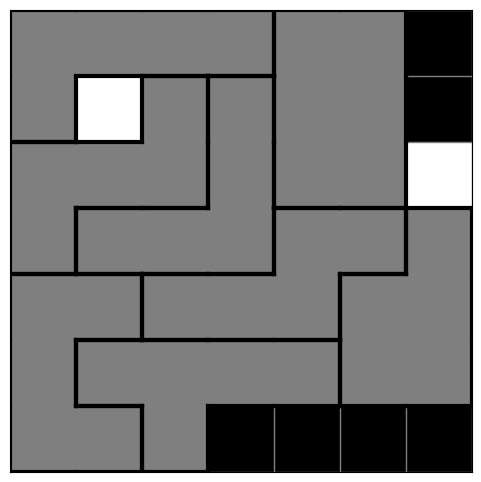

trial 305466 60470.0 seconds elapsed... 5.05 games/second, wins: 31
trial 305674 60485.0 seconds elapsed... 5.05 games/second, wins: 31
trial 305877 60500.0 seconds elapsed... 5.06 games/second, wins: 31
trial 306086 60515.1 seconds elapsed... 5.06 games/second, wins: 31
trial 306296 60530.1 seconds elapsed... 5.06 games/second, wins: 31
trial 306498 60545.1 seconds elapsed... 5.06 games/second, wins: 31
trial 306703 60560.2 seconds elapsed... 5.06 games/second, wins: 31
trial 306913 60575.3 seconds elapsed... 5.07 games/second, wins: 31
trial 307118 60590.3 seconds elapsed... 5.07 games/second, wins: 31
trial 307329 60605.3 seconds elapsed... 5.07 games/second, wins: 31
trial 307538 60620.4 seconds elapsed... 5.07 games/second, wins: 31
trial 307744 60635.4 seconds elapsed... 5.08 games/second, wins: 31
trial 307952 60650.4 seconds elapsed... 5.08 games/second, wins: 31
trial 308160 60665.4 seconds elapsed... 5.08 games/second, wins: 31
trial 308363 60680.5 seconds elapsed... 5.08 gam

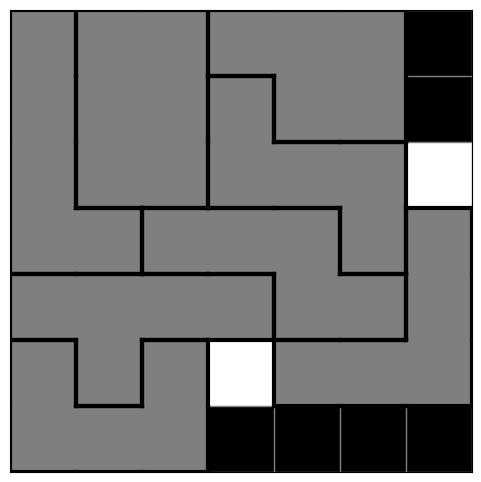

trial 309399 60755.7 seconds elapsed... 5.09 games/second, wins: 32
trial 309603 60770.7 seconds elapsed... 5.09 games/second, wins: 32
trial 309808 60785.8 seconds elapsed... 5.10 games/second, wins: 32
trial 310017 60800.8 seconds elapsed... 5.10 games/second, wins: 32
trial 310221 60815.8 seconds elapsed... 5.10 games/second, wins: 32
trial 310428 60830.8 seconds elapsed... 5.10 games/second, wins: 32
trial 310637 60845.9 seconds elapsed... 5.11 games/second, wins: 32
trial 310841 60861.0 seconds elapsed... 5.11 games/second, wins: 32
trial 311044 60876.0 seconds elapsed... 5.11 games/second, wins: 32
trial 311249 60891.1 seconds elapsed... 5.11 games/second, wins: 32
trial 311455 60906.1 seconds elapsed... 5.11 games/second, wins: 32
trial 311665 60921.1 seconds elapsed... 5.12 games/second, wins: 32
trial 311871 60936.2 seconds elapsed... 5.12 games/second, wins: 32
trial 312076 60951.3 seconds elapsed... 5.12 games/second, wins: 32


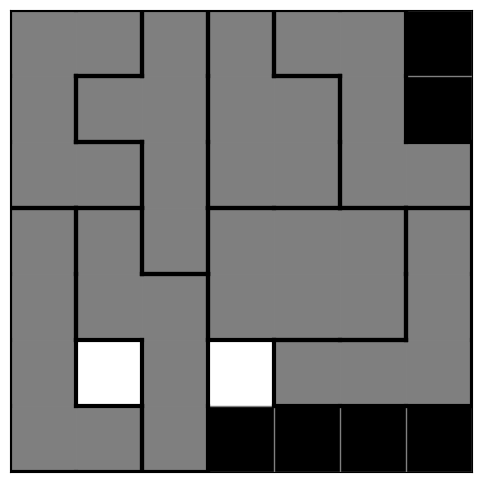

trial 312280 60966.3 seconds elapsed... 5.12 games/second, wins: 33
trial 312486 60981.3 seconds elapsed... 5.12 games/second, wins: 33
trial 312693 60996.4 seconds elapsed... 5.13 games/second, wins: 33
trial 312903 61011.4 seconds elapsed... 5.13 games/second, wins: 33
trial 313109 61026.4 seconds elapsed... 5.13 games/second, wins: 33
trial 313318 61041.4 seconds elapsed... 5.13 games/second, wins: 33


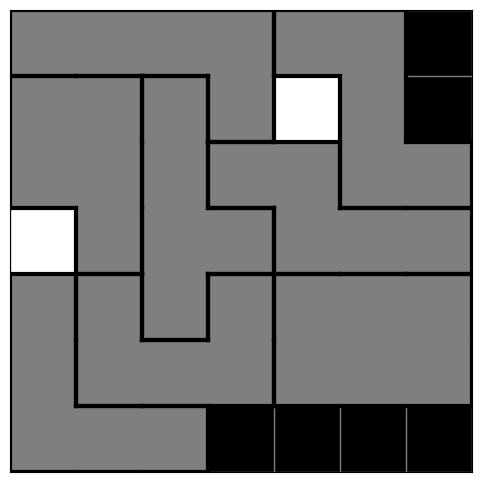

trial 313528 61056.5 seconds elapsed... 5.14 games/second, wins: 34
trial 313732 61071.5 seconds elapsed... 5.14 games/second, wins: 34
trial 313939 61086.6 seconds elapsed... 5.14 games/second, wins: 34
trial 314146 61101.6 seconds elapsed... 5.14 games/second, wins: 34
trial 314350 61116.6 seconds elapsed... 5.14 games/second, wins: 34
trial 314557 61131.7 seconds elapsed... 5.15 games/second, wins: 34
trial 314767 61146.7 seconds elapsed... 5.15 games/second, wins: 34
trial 314974 61161.8 seconds elapsed... 5.15 games/second, wins: 34
trial 315182 61176.8 seconds elapsed... 5.15 games/second, wins: 34
trial 315386 61191.9 seconds elapsed... 5.15 games/second, wins: 34
trial 315594 61206.9 seconds elapsed... 5.16 games/second, wins: 34
trial 315799 61222.0 seconds elapsed... 5.16 games/second, wins: 34
trial 316003 61237.1 seconds elapsed... 5.16 games/second, wins: 34
trial 316211 61252.1 seconds elapsed... 5.16 games/second, wins: 34
trial 316419 61267.1 seconds elapsed... 5.16 gam

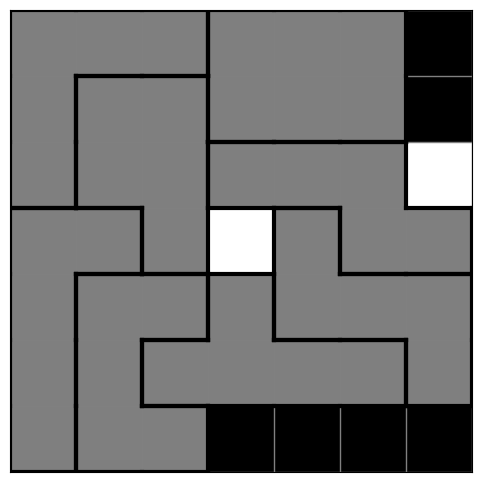

trial 333777 62953.3 seconds elapsed... 5.30 games/second, wins: 35
trial 333986 62968.4 seconds elapsed... 5.30 games/second, wins: 35
trial 334192 62983.4 seconds elapsed... 5.31 games/second, wins: 35
trial 334216 63073.1 seconds elapsed... 5.30 games/second, wins: 35
trial 334426 63088.2 seconds elapsed... 5.30 games/second, wins: 35
trial 334638 63103.3 seconds elapsed... 5.30 games/second, wins: 35
trial 334844 63118.3 seconds elapsed... 5.31 games/second, wins: 35
trial 334867 63193.8 seconds elapsed... 5.30 games/second, wins: 35
trial 335080 63208.8 seconds elapsed... 5.30 games/second, wins: 35
trial 335289 63223.8 seconds elapsed... 5.30 games/second, wins: 35
trial 335502 63238.8 seconds elapsed... 5.31 games/second, wins: 35
trial 335525 64138.5 seconds elapsed... 5.23 games/second, wins: 35
trial 335730 64153.5 seconds elapsed... 5.23 games/second, wins: 35
trial 335939 64168.6 seconds elapsed... 5.24 games/second, wins: 35
trial 336150 64183.6 seconds elapsed... 5.24 gam

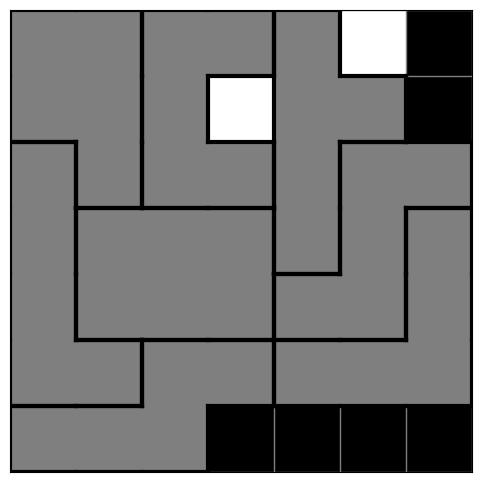

trial 357024 66751.8 seconds elapsed... 5.35 games/second, wins: 36
trial 357233 66766.9 seconds elapsed... 5.35 games/second, wins: 36
trial 357439 66781.9 seconds elapsed... 5.35 games/second, wins: 36
trial 357646 66796.9 seconds elapsed... 5.35 games/second, wins: 36
trial 357850 66812.0 seconds elapsed... 5.36 games/second, wins: 36
trial 358063 66827.0 seconds elapsed... 5.36 games/second, wins: 36
trial 358273 66842.0 seconds elapsed... 5.36 games/second, wins: 36
trial 358483 66857.1 seconds elapsed... 5.36 games/second, wins: 36
trial 358686 66872.1 seconds elapsed... 5.36 games/second, wins: 36
trial 358892 66887.1 seconds elapsed... 5.37 games/second, wins: 36
trial 359100 66902.2 seconds elapsed... 5.37 games/second, wins: 36
trial 359307 66917.2 seconds elapsed... 5.37 games/second, wins: 36
trial 359517 66932.3 seconds elapsed... 5.37 games/second, wins: 36
trial 359721 66947.3 seconds elapsed... 5.37 games/second, wins: 36
trial 359929 66962.4 seconds elapsed... 5.38 gam

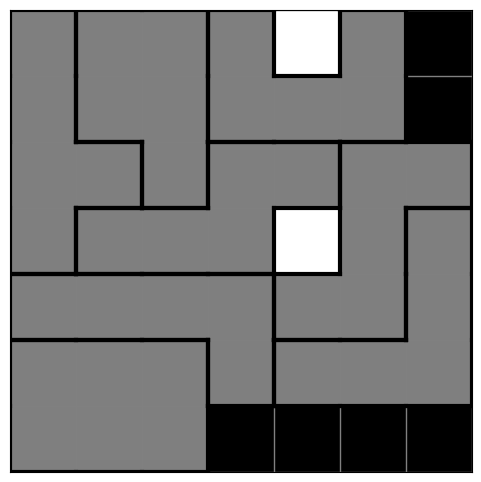

trial 361174 67052.5 seconds elapsed... 5.39 games/second, wins: 37
trial 361378 67067.5 seconds elapsed... 5.39 games/second, wins: 37
trial 361590 67082.6 seconds elapsed... 5.39 games/second, wins: 37
trial 361799 67097.7 seconds elapsed... 5.39 games/second, wins: 37
trial 362011 67112.7 seconds elapsed... 5.39 games/second, wins: 37
trial 362216 67127.7 seconds elapsed... 5.40 games/second, wins: 37
trial 362421 67142.7 seconds elapsed... 5.40 games/second, wins: 37


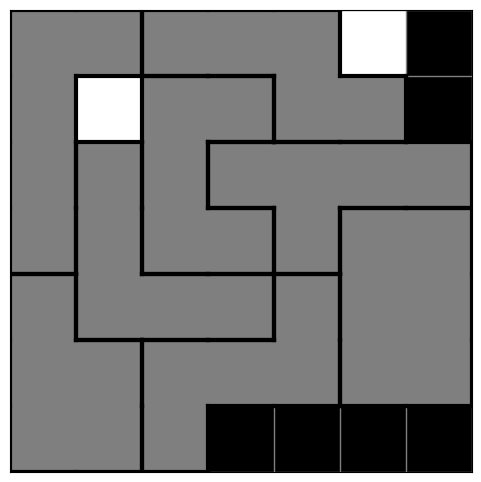

trial 362631 67157.8 seconds elapsed... 5.40 games/second, wins: 38
trial 362834 67172.8 seconds elapsed... 5.40 games/second, wins: 38
trial 363041 67187.8 seconds elapsed... 5.40 games/second, wins: 38
trial 363247 67202.9 seconds elapsed... 5.41 games/second, wins: 38
trial 363458 67218.0 seconds elapsed... 5.41 games/second, wins: 38
trial 363664 67233.0 seconds elapsed... 5.41 games/second, wins: 38
trial 363869 67248.0 seconds elapsed... 5.41 games/second, wins: 38
trial 364074 67263.1 seconds elapsed... 5.41 games/second, wins: 38
trial 364277 67278.1 seconds elapsed... 5.41 games/second, wins: 38
trial 364486 67293.1 seconds elapsed... 5.42 games/second, wins: 38


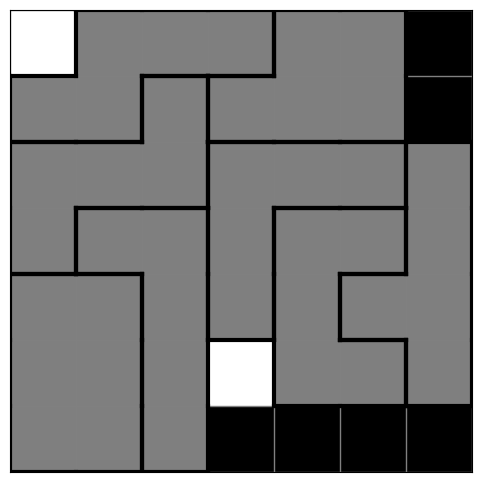

trial 364693 67308.2 seconds elapsed... 5.42 games/second, wins: 39
trial 364901 67323.2 seconds elapsed... 5.42 games/second, wins: 39
trial 365108 67338.2 seconds elapsed... 5.42 games/second, wins: 39
trial 365316 67353.3 seconds elapsed... 5.42 games/second, wins: 39
trial 365525 67368.3 seconds elapsed... 5.43 games/second, wins: 39
trial 365732 67383.4 seconds elapsed... 5.43 games/second, wins: 39
trial 365940 67398.5 seconds elapsed... 5.43 games/second, wins: 39
trial 366144 67413.6 seconds elapsed... 5.43 games/second, wins: 39
trial 366347 67428.6 seconds elapsed... 5.43 games/second, wins: 39
trial 366553 67443.6 seconds elapsed... 5.43 games/second, wins: 39
trial 366756 67458.6 seconds elapsed... 5.44 games/second, wins: 39
trial 366960 67473.6 seconds elapsed... 5.44 games/second, wins: 39
trial 367168 67488.7 seconds elapsed... 5.44 games/second, wins: 39
trial 367378 67503.8 seconds elapsed... 5.44 games/second, wins: 39
trial 367585 67518.8 seconds elapsed... 5.44 gam

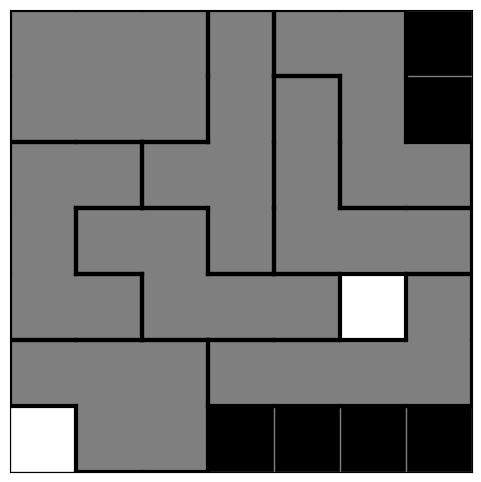

trial 374550 68030.1 seconds elapsed... 5.51 games/second, wins: 40
trial 374757 68045.2 seconds elapsed... 5.51 games/second, wins: 40
trial 374959 68060.2 seconds elapsed... 5.51 games/second, wins: 40
trial 375164 68075.2 seconds elapsed... 5.51 games/second, wins: 40
trial 375376 68090.3 seconds elapsed... 5.51 games/second, wins: 40
trial 375587 68105.3 seconds elapsed... 5.51 games/second, wins: 40
trial 375793 68120.4 seconds elapsed... 5.52 games/second, wins: 40
trial 375999 68135.4 seconds elapsed... 5.52 games/second, wins: 40
trial 376208 68150.5 seconds elapsed... 5.52 games/second, wins: 40
trial 376414 68165.5 seconds elapsed... 5.52 games/second, wins: 40
trial 376622 68180.5 seconds elapsed... 5.52 games/second, wins: 40
trial 376833 68195.6 seconds elapsed... 5.53 games/second, wins: 40
trial 377043 68210.6 seconds elapsed... 5.53 games/second, wins: 40
trial 377247 68225.7 seconds elapsed... 5.53 games/second, wins: 40
trial 377456 68240.7 seconds elapsed... 5.53 gam

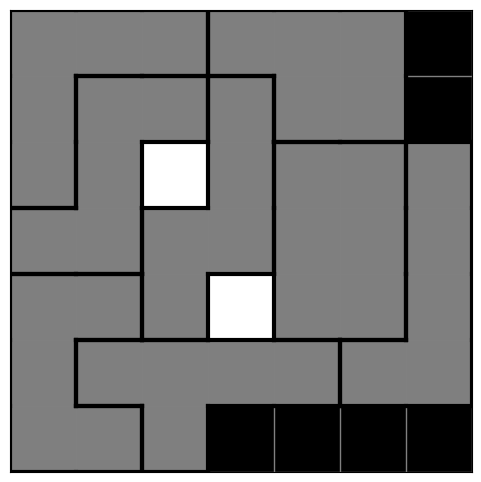

trial 402330 70060.0 seconds elapsed... 5.74 games/second, wins: 41
trial 402527 70075.1 seconds elapsed... 5.74 games/second, wins: 41
trial 402730 70090.1 seconds elapsed... 5.75 games/second, wins: 41
trial 402930 70105.2 seconds elapsed... 5.75 games/second, wins: 41
trial 403130 70120.2 seconds elapsed... 5.75 games/second, wins: 41
trial 403327 70135.2 seconds elapsed... 5.75 games/second, wins: 41
trial 403532 70150.3 seconds elapsed... 5.75 games/second, wins: 41
trial 403730 70165.4 seconds elapsed... 5.75 games/second, wins: 41
trial 403924 70180.4 seconds elapsed... 5.76 games/second, wins: 41
trial 404121 70195.4 seconds elapsed... 5.76 games/second, wins: 41
trial 404323 70210.4 seconds elapsed... 5.76 games/second, wins: 41
trial 404524 70225.5 seconds elapsed... 5.76 games/second, wins: 41
trial 404720 70240.5 seconds elapsed... 5.76 games/second, wins: 41
trial 404924 70255.5 seconds elapsed... 5.76 games/second, wins: 41
trial 405123 70270.6 seconds elapsed... 5.77 gam

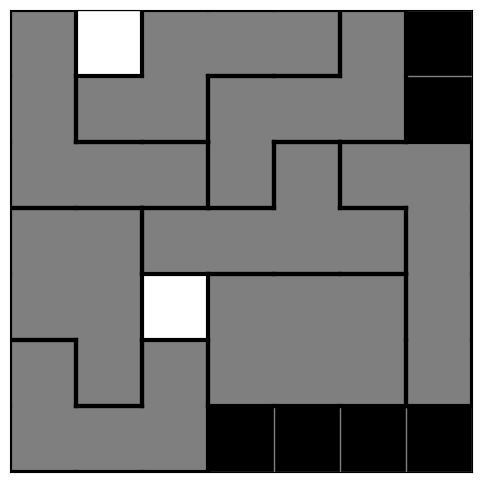

trial 411273 70736.6 seconds elapsed... 5.81 games/second, wins: 42
trial 411470 70751.6 seconds elapsed... 5.82 games/second, wins: 42
trial 411677 70766.7 seconds elapsed... 5.82 games/second, wins: 42
trial 411878 70781.7 seconds elapsed... 5.82 games/second, wins: 42
trial 412078 70796.8 seconds elapsed... 5.82 games/second, wins: 42
trial 412277 70811.8 seconds elapsed... 5.82 games/second, wins: 42
trial 412476 70826.8 seconds elapsed... 5.82 games/second, wins: 42
trial 412678 70841.8 seconds elapsed... 5.83 games/second, wins: 42
trial 412872 70856.8 seconds elapsed... 5.83 games/second, wins: 42
trial 413065 70871.8 seconds elapsed... 5.83 games/second, wins: 42
trial 413269 70886.9 seconds elapsed... 5.83 games/second, wins: 42
trial 413465 70901.9 seconds elapsed... 5.83 games/second, wins: 42
trial 413672 70917.0 seconds elapsed... 5.83 games/second, wins: 42
trial 413879 70932.1 seconds elapsed... 5.83 games/second, wins: 42
trial 414076 70947.1 seconds elapsed... 5.84 gam

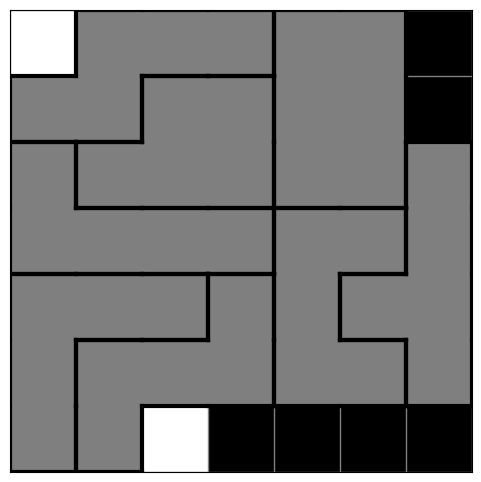

trial 416866 71157.7 seconds elapsed... 5.86 games/second, wins: 43
trial 417071 71172.7 seconds elapsed... 5.86 games/second, wins: 43
trial 417268 71187.8 seconds elapsed... 5.86 games/second, wins: 43
trial 417469 71202.8 seconds elapsed... 5.86 games/second, wins: 43
trial 417667 71217.8 seconds elapsed... 5.86 games/second, wins: 43
trial 417866 71232.9 seconds elapsed... 5.87 games/second, wins: 43
trial 418060 71248.0 seconds elapsed... 5.87 games/second, wins: 43
trial 418257 71263.0 seconds elapsed... 5.87 games/second, wins: 43
trial 418456 71278.1 seconds elapsed... 5.87 games/second, wins: 43
trial 418655 71293.1 seconds elapsed... 5.87 games/second, wins: 43
trial 418853 71308.1 seconds elapsed... 5.87 games/second, wins: 43
trial 419052 71323.2 seconds elapsed... 5.88 games/second, wins: 43
trial 419248 71338.2 seconds elapsed... 5.88 games/second, wins: 43
trial 419446 71353.2 seconds elapsed... 5.88 games/second, wins: 43
trial 419645 71368.3 seconds elapsed... 5.88 gam

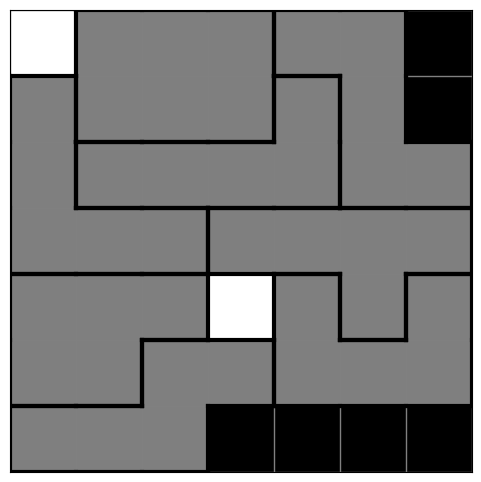

trial 427545 71954.8 seconds elapsed... 5.94 games/second, wins: 44
trial 427741 71969.8 seconds elapsed... 5.94 games/second, wins: 44
trial 427941 71984.9 seconds elapsed... 5.94 games/second, wins: 44
trial 428132 71999.9 seconds elapsed... 5.95 games/second, wins: 44
trial 428328 72014.9 seconds elapsed... 5.95 games/second, wins: 44
trial 428523 72030.0 seconds elapsed... 5.95 games/second, wins: 44
trial 428715 72045.0 seconds elapsed... 5.95 games/second, wins: 44
trial 428908 72060.0 seconds elapsed... 5.95 games/second, wins: 44
trial 429100 72075.0 seconds elapsed... 5.95 games/second, wins: 44
trial 429289 72090.0 seconds elapsed... 5.95 games/second, wins: 44
trial 429483 72105.1 seconds elapsed... 5.96 games/second, wins: 44
trial 429676 72120.1 seconds elapsed... 5.96 games/second, wins: 44
trial 429870 72135.1 seconds elapsed... 5.96 games/second, wins: 44
trial 430072 72150.1 seconds elapsed... 5.96 games/second, wins: 44
trial 430269 72165.1 seconds elapsed... 5.96 gam

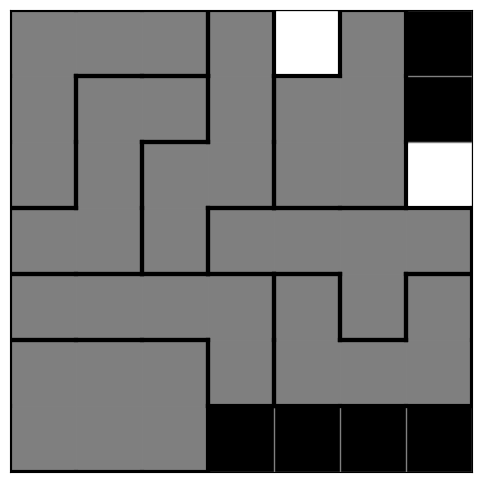

trial 443694 73188.0 seconds elapsed... 6.06 games/second, wins: 45
trial 443899 73203.1 seconds elapsed... 6.06 games/second, wins: 45
trial 444100 73218.1 seconds elapsed... 6.07 games/second, wins: 45
trial 444303 73233.2 seconds elapsed... 6.07 games/second, wins: 45


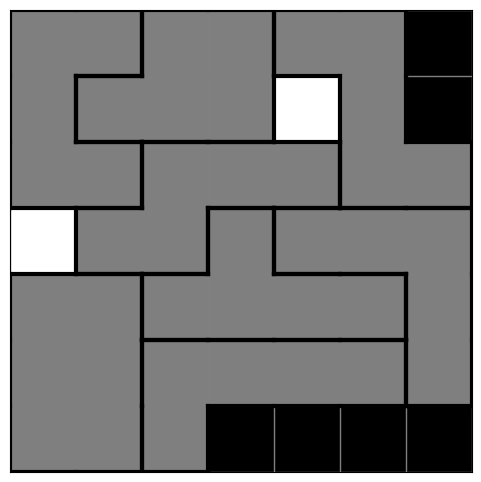

trial 444504 73248.2 seconds elapsed... 6.07 games/second, wins: 46
trial 444712 73263.2 seconds elapsed... 6.07 games/second, wins: 46
trial 444913 73278.2 seconds elapsed... 6.07 games/second, wins: 46
trial 445118 73293.2 seconds elapsed... 6.07 games/second, wins: 46
trial 445322 73308.3 seconds elapsed... 6.07 games/second, wins: 46
trial 445525 73323.3 seconds elapsed... 6.08 games/second, wins: 46
trial 445731 73338.4 seconds elapsed... 6.08 games/second, wins: 46
trial 445937 73353.4 seconds elapsed... 6.08 games/second, wins: 46
trial 446142 73368.5 seconds elapsed... 6.08 games/second, wins: 46
trial 446341 73383.5 seconds elapsed... 6.08 games/second, wins: 46
trial 446554 73398.6 seconds elapsed... 6.08 games/second, wins: 46
trial 446756 73413.6 seconds elapsed... 6.09 games/second, wins: 46
trial 446960 73428.6 seconds elapsed... 6.09 games/second, wins: 46
trial 447169 73443.7 seconds elapsed... 6.09 games/second, wins: 46
trial 447373 73458.7 seconds elapsed... 6.09 gam

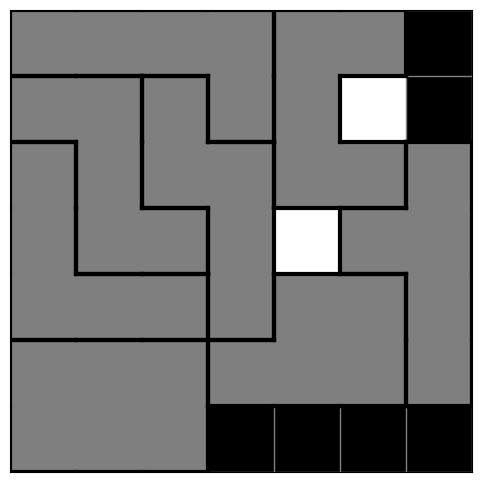

trial 450628 73699.3 seconds elapsed... 6.11 games/second, wins: 47
trial 450830 73714.3 seconds elapsed... 6.12 games/second, wins: 47
trial 451030 73729.3 seconds elapsed... 6.12 games/second, wins: 47
trial 451234 73744.4 seconds elapsed... 6.12 games/second, wins: 47
trial 451439 73759.5 seconds elapsed... 6.12 games/second, wins: 47
trial 451637 73774.6 seconds elapsed... 6.12 games/second, wins: 47
trial 451843 73789.6 seconds elapsed... 6.12 games/second, wins: 47
trial 452051 73804.6 seconds elapsed... 6.12 games/second, wins: 47
trial 452260 73819.7 seconds elapsed... 6.13 games/second, wins: 47
trial 452463 73834.7 seconds elapsed... 6.13 games/second, wins: 47
trial 452670 73849.8 seconds elapsed... 6.13 games/second, wins: 47
trial 452875 73864.8 seconds elapsed... 6.13 games/second, wins: 47
trial 453075 73879.8 seconds elapsed... 6.13 games/second, wins: 47
trial 453276 73894.9 seconds elapsed... 6.13 games/second, wins: 47
trial 453478 73909.9 seconds elapsed... 6.14 gam

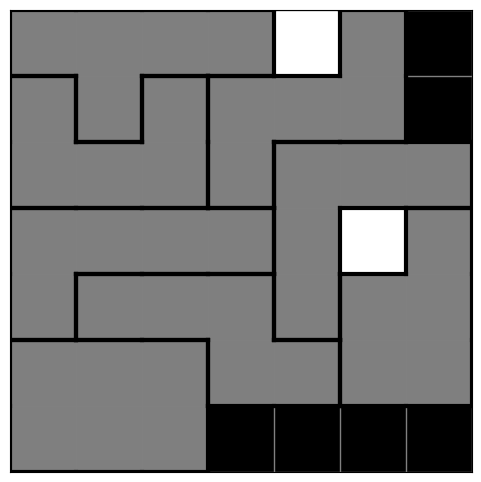

trial 463011 74616.4 seconds elapsed... 6.21 games/second, wins: 48
trial 463214 74631.5 seconds elapsed... 6.21 games/second, wins: 48
trial 463412 74646.5 seconds elapsed... 6.21 games/second, wins: 48
trial 463615 74661.5 seconds elapsed... 6.21 games/second, wins: 48
trial 463820 74676.6 seconds elapsed... 6.21 games/second, wins: 48
trial 464021 74691.6 seconds elapsed... 6.21 games/second, wins: 48
trial 464227 74706.7 seconds elapsed... 6.21 games/second, wins: 48
trial 464432 74721.7 seconds elapsed... 6.22 games/second, wins: 48


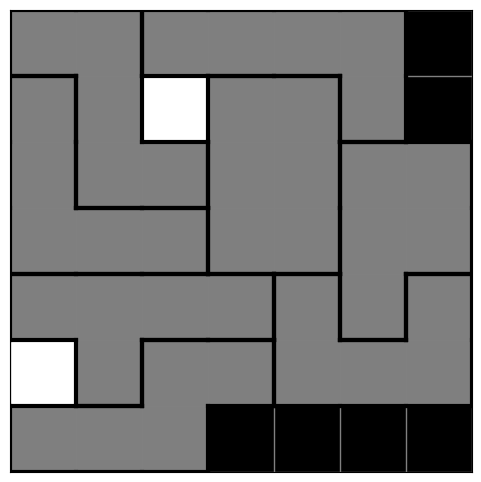

trial 464634 74736.8 seconds elapsed... 6.22 games/second, wins: 49
trial 464838 74751.8 seconds elapsed... 6.22 games/second, wins: 49
trial 465043 74766.9 seconds elapsed... 6.22 games/second, wins: 49
trial 465244 74781.9 seconds elapsed... 6.22 games/second, wins: 49
trial 465443 74796.9 seconds elapsed... 6.22 games/second, wins: 49
trial 465650 74811.9 seconds elapsed... 6.22 games/second, wins: 49
trial 465849 74827.0 seconds elapsed... 6.23 games/second, wins: 49
trial 466047 74842.0 seconds elapsed... 6.23 games/second, wins: 49
trial 466246 74857.0 seconds elapsed... 6.23 games/second, wins: 49
trial 466450 74872.1 seconds elapsed... 6.23 games/second, wins: 49
trial 466653 74887.1 seconds elapsed... 6.23 games/second, wins: 49
trial 466850 74902.1 seconds elapsed... 6.23 games/second, wins: 49
trial 467055 74917.2 seconds elapsed... 6.23 games/second, wins: 49
trial 467261 74932.2 seconds elapsed... 6.24 games/second, wins: 49
trial 467464 74947.2 seconds elapsed... 6.24 gam

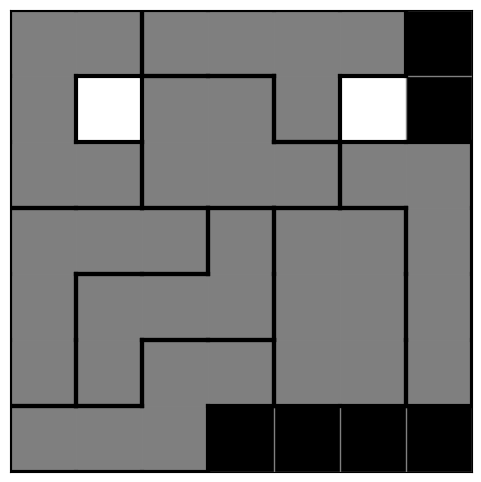

trial 470979 75202.7 seconds elapsed... 6.26 games/second, wins: 50
trial 471198 75217.7 seconds elapsed... 6.26 games/second, wins: 50


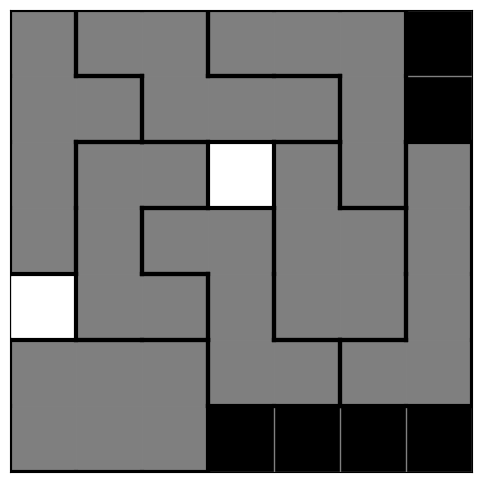

trial 471406 75232.8 seconds elapsed... 6.27 games/second, wins: 51
trial 471618 75247.8 seconds elapsed... 6.27 games/second, wins: 51
trial 471829 75262.9 seconds elapsed... 6.27 games/second, wins: 51


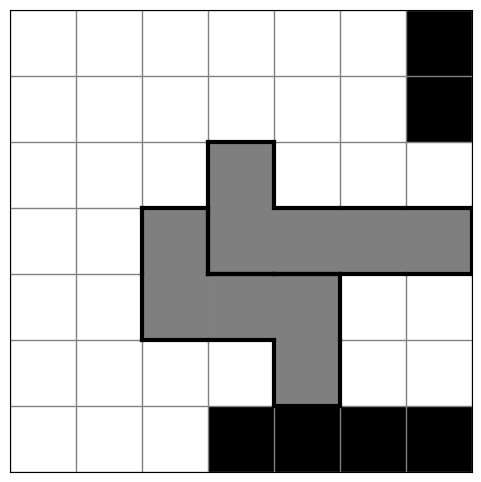

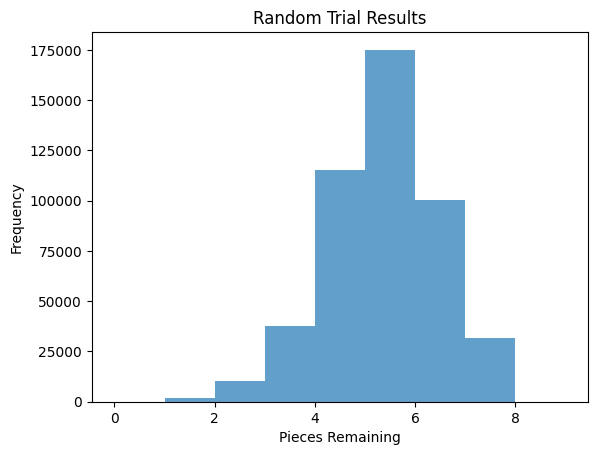

Trials: 471947, Success rate: 0.01%, wins: 51
51


In [47]:
import time

start_time = time.time()
last_print = start_time

i = 0
remaining_pieces = []
win = 0
try:
    while True:
        i += 1
        env, done, truncated, terminal_action = test_random_trial(-1,-1)
        remaining_pieces.append(sum(env.remaining_pieces))
        if done: # win
            env.visualize()
            win += 1
        current_time = time.time()
        if current_time - last_print >= 15:
            elapsed = current_time - start_time
            print(f"trial {i} {elapsed:.1f} seconds elapsed... {i/elapsed:.2f} games/second, wins: {win}")
            last_print = current_time

except KeyboardInterrupt:
    env.visualize()

plt.hist(remaining_pieces, bins=range(10), alpha=0.7)
plt.xlabel('Pieces Remaining')
plt.ylabel('Frequency')
plt.title('Random Trial Results')
plt.savefig('trial_results.png')
plt.show()

print(f"Trials: {i}, Success rate: {remaining_pieces.count(0)/i:.2%}, wins: {win}")
print(win)

~~most of the time we end up with 2 remaining pieces when we place them all randomly~~

~~bricking the game in the step function when islands of 2-4 empty cells remain reduces the number of trials required by 10-20x.~~

- bricking the game on (islands of 3,4,9,14), (an island of 2 any number of islands of 1), or (more than 2 islands of 1) brings us up to 0.2% success

Now we're requiring a solution to a specific date: win rate is somewhere < 0.01%, not surprising

In [20]:
has_islands(env.grid)

np.True_